# ContactTracing tutorial

This tutorial demonstrates ContactTracing analysis, as described in: Non-cell-autonomous cancer progression from chromosomal instability by Li, J et al , 2023: https://www.nature.com/articles/s41586-023-06464-z. 

This pipeline uses annotated and filtered single-cell data, as well as a database of ligand/receptors, to find detect putative interactions in which:
- the ligand is differentially expressed in one cell type between two conditions
- the expression of the receptor produces an 'interaction effect', characterized by a condition-specific transcriptional response to receptor expression

To start, you need to set these variables in the following code block:
- `anndata_file`: path to h5ad file containing the anndata object with scRNA-seq data
    - The object should have a layer called 'logX' with log-normalized counts
        - We normalize each cell to sum to 10000, then log transform with: adata.layers['logX'] =  np.log10(X + 0.1) - np.log10(0.1). (It is assumed this normalization is already done)
    - It should have a column .obs['cell type'] with clean cell type annotations (mis-annotated cells may produce spurious results)
    - It should have a columns .obs['sample'] with sample name
    - It should have a column .obs['condition'] with condition, we need two conditions to compare (other cells will be ignored). The condition names should be simple (characters should be alphanumeric, underscore, or period, should start with alphabetic character).
    - The index of the .var matrix should map to gene names used in the interactions file. There should be no duplicates in adata.var.index
    - The data set should be filtered for quality cells only with confident cell type annotations, high mitochondrial rate removed, likely doublets removed, etc
- `interactions_file`: text file (tab-delimited) with list of ligands and receptors, should have columns with header 'ligand' and 'receptor' giving ligand/receptor pairs. An example file for mouse can be found in the file `data/interactions_mm10.txt` directory of this tutorial.
- The name of two conditions to compare (`condition1` and `condition2`), tests will compare condition1 vs condition2, so that logFC will be positive when condition1 is up.


__Anndata files used for "Cancer cell non-autonomous tumor progression from chromosomal instability" (Li, Hubisz, Earlie et al) can be found here: 10.5281/zenodo.8061222__

__Note about using human data (or other data sampled across heterogeneous individuals):__

ContactTracing is designed to detect differences between samples from two different conditions. The ideal/target application would use laboratory specimens (such as mouse) with identical genetics and environment, where only the condition of interest has been perturbed. With human subjects, there is likely too much variability between subjects, unrelated to the conditions being tested. This will lead to a huge number of interaction effects that are probably mostly false positives. However, we do think there are some situations where it may be possible to run ContactTracing on human data. In general, this will be when the two 'conditions' are from the same individual, for example, before/after treatment. If you have multiple individuals with samples from both conditions, then we suggest two possible strategies:
- Run ContactTracing independently on each individual, comparing the two conditions. The results from each individual can then be intersected to detect interactions common across patients. We recommend this approach as more robustly correcting for differences between inidividuals. However, it may suffer from lack of power, if not enough cells are collected in each sample.
- Combine all data and run ContactTracing between conditions, using the patient identity as a covariate. This may help alleviate false positives due to differences between individuals, though not as robustly as the first approach. However, this approach may be necessary if the cell counts per individual (and especially within each cell type) are too low to detect interactions without combining data.

See the section below on [Data Visualization](#visualization) for more discussion of whether data is appropriate for ContactTracing analysis


In [1]:
## Set input file names, conditions, and output directories
#anndata_file = '/data/adata_for_tutorial.h5ad'
#interactions_file='/data/ContactTracing_tutorial/data/interactions_mm10.txt'

# this should be location of tutorial files/scripts
#tutorial_dir='/data/ContactTracing_tutorial'

# set output directory
#output_dir='/data/tutorial_output'

## Set input file names, conditions, and output directories
#anndata_file = '/home/ubuntu/cart.contact.tracing/All.tissues.v2.1.h5ad'
anndata_file = '../../data_save/temp_int.h5ad'
interactions_file='data/interactions.txt'

# this should be location of tutorial files/scripts
tutorial_dir='./'

# set output directory
#output_dir='/home/ubuntu/cart.contact.tracing'
output_dir='../MCAK-iso/'

# tmp_output_dir for unimportant/intermediate output
tmp_output_dir=f'{output_dir}/tmp/NOBACKUP'
!mkdir -p {tmp_output_dir}

In [2]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import subprocess
import multiprocessing
from multiprocessing import Pool, freeze_support
from functools import partial
from itertools import product
from kneed import KneeLocator
from adjustText import adjust_text
import statsmodels
import sys
import warnings
from sklearn.preprocessing import scale
from IPython.display import Image

In [3]:
sys.path.append(f'{tutorial_dir}/python')

In [4]:
import contactTracing_library as ct

# we use a couple functions from palantir source code
import palantir_functions as palantirFuncs

In [5]:
!which python


/home/ubuntu/anaconda3/bin/python


In [6]:
# this is just for debugging, if any changes are made to ContactTracing_library.py, reload
importlib.reload(ct)

<module 'contactTracing_library' from '/home/ubuntu/ContactTracing/lkb1_mouse/CT/CT/.//python/contactTracing_library.py'>

In [7]:
# It seems to be much faster running R with these environment Variables set, surprisingly, turning off multithreading improves runtime more than 2 fold.
# Paralellization is instead achieved by running multiple R commands simultaneously
Rcommand='MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R'

## Load / process scRNA-seq data

In [8]:
adata = sc.read(anndata_file)

# make sure these fields are empty, some scanpy opeartions fail otherwise
adata.obs.index.name=None
adata.var.index.name=None

adata

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 23542 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'predicted_doublets', 'doublet_scores', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'celltype_moused_main', 'celltype_moused_fine', 'ID', 'RNA_snn_res.0.5', 'lkb1.tumor_1', 'lkb1.immune_1', 'lkb1.tcells_1', 'celltypes_major_v1', 'celltypes_minor_v1', 'ID_major'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

### Make sure cell barcodes are unique

In [9]:
numdup = sum(adata.obs.index.duplicated())
print(f'{numdup} duplicated barcodes')
if numdup > 0:
    adata.obs_names_make_unique()
    numdup = sum(adata.obs.index.duplicated())
    print(f'now {numdup} duplicated barcodes')

0 duplicated barcodes


In [10]:
#adata.obs['condition'] = adata.obs['Path_Response_Classification']

In [11]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps',
       'percent.rpl', 'percent.rp', 'predicted_doublets', 'doublet_scores',
       'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters',
       'celltype_moused_main', 'celltype_moused_fine', 'ID', 'RNA_snn_res.0.5',
       'lkb1.tumor_1', 'lkb1.immune_1', 'lkb1.tcells_1', 'celltypes_major_v1',
       'celltypes_minor_v1', 'ID_major'],
      dtype='object')

In [12]:
set(adata.obs['ID_major'])

{'MCAK-PD1', 'MCAK-iso', 'PD1', 'cGASKO-PD1', 'cGASKO-iso', 'iso'}

### Fix condition and cell type names

Make sure condition and cell types do not have special characters.  The code below replaces spaces and slashes with underscores, and removes pound signs. Other strange characters may cause problems, I recommend replacing anything besides alphanumerics and underscores.

In [13]:

adata.obs['condition'] = adata.obs['ID_major']
adata.obs['condition'] = adata.obs['condition'].str.replace('-', '')

#adata.obs['condition'] = adata.obs['Recurrence']
adata.obs['condition'].value_counts()

condition
MCAKPD1      6141
PD1          5709
iso          4996
cGASKOPD1    3287
MCAKiso      2614
cGASKOiso     795
Name: count, dtype: int64

In [14]:
#adata.obs['condition'] = [x.replace(' ', '_').replace('/', '_').replace('#', '') for x in adata.obs['condition'].astype(str)]
adata.obs['condition'] = [x.replace(' ', '_').replace('/', '_').replace('#', '').replace('+', '_') for x in adata.obs['condition'].astype(str)]
adata.obs['condition'].value_counts()

condition
MCAKPD1      6141
PD1          5709
iso          4996
cGASKOPD1    3287
MCAKiso      2614
cGASKOiso     795
Name: count, dtype: int64

In [15]:

#adata.obs['cell type']=adata.obs['major_celltypes_v2']
adata.obs['cell type']=adata.obs['celltypes_minor_v1']
#adata = adata[adata.obs['cell type'].isin(['B-cells',
# 'Endothelial',
# 'Fibroblasts',
# 'Myeloid',
# 'Neuronal',
# 'Others',
# 'malignant'])]
#adata.obs['cell type'] = adata.obs['cell type'].str.replace(r'\(|\)', '', regex=True)
#adata.obs['cell type'] = adata.obs['cell type'].str.replace(r'[\(\).]', '', regex=True)

adata.obs['cell type'] = adata.obs['cell type'].str.replace(' ', '')
adata.obs['cell type'] = adata.obs['cell type'].str.replace('-', '')

adata.obs['cell type'].value_counts()


cell type
Malignant      16498
Myeloid         2626
Fibroblasts     2485
Endothelial     1093
Tcells           699
Bcells            84
Other             57
Name: count, dtype: int64

In [16]:
set(adata.obs['cell type'])

{'Bcells',
 'Endothelial',
 'Fibroblasts',
 'Malignant',
 'Myeloid',
 'Other',
 'Tcells'}

In [17]:
#adata.obs['cell type'] = [x.replace(' ', '_').replace('/', '_').replace('#', '') for x in adata.obs['cell type'].astype(str)]
#adata.obs['cell type'].value_counts()

### Set condition1 and condition2

All tests will be done in the form: condition1 vs condition2.  So, log2FC will be __positive__ when condition1 is expressed higher than condition2

In [18]:
#condition1 = 'car.t.construct'
#condition2 = 'negative'

condition1 = 'MCAKiso'
condition2 = 'iso'

In [19]:
keepData = (adata.obs['condition'] == condition1) | (adata.obs['condition'] == condition2)
print(f'Removing {sum(~keepData)} cells with condition != ({condition1} or {condition2})')
adata = adata[keepData]

Removing 15932 cells with condition != (MCAKiso or iso)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [20]:
from collections import Counter
Counter(adata[adata.obs['condition'] == 'MCAK-iso'].obs["cell type"])

Counter()

### Remove small cell types, if any

There needs to be sufficient cell counts in both conditions to get results. Here we remove any cell types with < 50 cells in either condition

In [21]:
minCell = 10

In [22]:
ctcounts = adata.obs[['cell type','condition']].value_counts()
remove_cellTypes = ctcounts[ctcounts < minCell].reset_index()['cell type'].unique()
if len(remove_cellTypes) > 0:
    tmpstr = ','.join(remove_cellTypes)
    print(f'Removing celltypes: {tmpstr}')
    print(f'Original ncell {adata.shape[0]}')
    adata = adata[~adata.obs['cell type'].isin(remove_cellTypes)]
    print(f'New ncell {adata.shape[0]}')
else:
    print('Keeping all cell types')

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Removing celltypes: Other,Tcells
Original ncell 7610
New ncell 7449


In [23]:
adata = adata[~adata.obs['cell type'].isin(['Bcells'])]


### Compute cngeneson, covariate used for MAST

Represents the scaled number of expressed genes in each cell

In [24]:

del adata.raw
np.isnan(adata.X).any()


False

In [25]:
#sc.pp.log1p(adata)

In [26]:
adata.layers['logX'] = adata.X

In [27]:
adata.obs['cngeneson'] = scale(np.sum(adata.layers['logX'] > 0, axis=1))

In [28]:
adata

AnnData object with n_obs × n_vars = 7423 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'predicted_doublets', 'doublet_scores', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'celltype_moused_main', 'celltype_moused_fine', 'ID', 'RNA_snn_res.0.5', 'lkb1.tumor_1', 'lkb1.immune_1', 'lkb1.tcells_1', 'celltypes_major_v1', 'celltypes_minor_v1', 'ID_major', 'condition', 'cell type', 'cngeneson'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logX'
    obsp: 'distances'

<a id='visualization'></a>
### Data visualization

This is not necessary for ContactTracing, but useful to assess whether data is appropriate for ContactTracing analysis.

In [29]:
adata.X = adata.layers['logX']


In [30]:
adata.obs['sample']=adata.obs['orig.ident']

__The data above looks good, a single cluster per cell type: mixing between conditions/samples within each cluster__

If your data does not cluster like this, you are likely to get spurious results from ContactTracing. For example, if the two conditions are in two separate clusters for a single cell type, you will likely see a huge number of 'interaction effects' in the receptors for that cell type. 

In [31]:
adata.obs[['sample', 'condition']].value_counts()

sample  condition
LAC12   MCAKiso      2240
LAC4    iso          2193
LAC6    iso          1364
LAC5    iso          1268
LAC10   MCAKiso       232
LAC11   MCAKiso       126
Name: count, dtype: int64

## Read interactions file

In [32]:
interactions = pd.read_csv(interactions_file, sep='\t')
interactions

,ligand,receptor
0,Wnt9a,Egfr
1,Wnt9a,Fzd9
2,Wnt9a,Fzd4
3,Wnt9a,Fzd7
4,Ccl2,Ccr4
...,...,...
1880,F11r,aLb2_complex
1881,NKG2D_II_receptor,Ulbp1
1882,PlexinA1_complex1,Sema6d
1883,PlexinA1_complex2,Sema6d


__Should not have any duplicated interactions; if so, remove__

In [33]:
f = interactions[['ligand', 'receptor']].duplicated()
if sum(f) > 0:
    print(f'Removing {sum(f)} duplicated interactions')
    interactions = interactions.loc[~f]

__Remove any interactions that don't have both genes in adata__

In [34]:
allgenes = list(set(adata.var.index))
f = interactions['ligand'].isin(allgenes) & (interactions['receptor'].isin(allgenes))
print(f'Removing {sum(~f)} interactions that do not have both genes in adata')
interactions = interactions.loc[f]

Removing 1711 interactions that do not have both genes in adata


## Find ligands that are differentially expressed in each cell type

In [35]:
output_dir

'../MCAK-iso/'

In [36]:
mast_outdir=f'{output_dir}/MAST_between_conditions'
!mkdir -p {mast_outdir}

In [37]:
# set this list to all interesting ligand cell types
ligand_cellTypes = list(adata.obs['cell type'].unique())
ligand_cellTypes

['Malignant', 'Myeloid', 'Endothelial', 'Fibroblasts']

__Run MAST on each cell type, comparing the two conditions__

Note: cngeneson is a recommended covariate in this analysis.

You can add other covariates to the analysis by adding them to the --covariates option, as a comma-delimited list. For example, to add sample name, for example, use the argument: --covariates cngeneson,sample. This requires adata.obs['sample'] ato be defined. Note, it will not make sense for sample to be a covariate unless individual samples are represented in both conditions.

In [38]:
ligands = list(interactions['ligand'].unique())

In [39]:
## Each command will take several minutes (or more, depending on data set size).
## Set this value to False if you prefer to copy commands to a script and run outside the notebook.
runCommands=True

In [40]:
len(ligand_cellTypes)

4

The command below runs MAST on each cell type.

Note the numCore option below, this is how many cores will be used by each command. 

Note also that each command will take some RAM (the amount depending on # of cells in each cell type, and # of genes). You may want to run 'top' on your server and see how much RAM is being used. It is possible that RAM will be the bottleneck, rather than # of cores available. In this case you will need to kill the jobs and restart with fewer cores, or run them one a time.

Alternatively, you can set runCommands=False. Then it will just print the commands that need to be run. You can copy/paste the commands into a terminal within the docker container. Or, you can write them to a file, and use gnu parallel to run them in parallel, with a command like 'parallel -j 5 < commands.txt' (this will run 5 commands simultaneously, it should also be done in a terminal within the docker container).

In [41]:
wait=True   # if wait=True, run each command one at a time. Otherwise, run them all at once (make sure to have sufficient cores/RAM).
            # if wait=False, this command will finish quickly, but MAST jobs will be running in the background, you will need to wait for them
            # to finish before proceeding. (The next block will tell you if any output files are not found).
numCore=10  # number of cores to use for each MAST command

runCommands=True  #if False, just print commands (do not run them). See comments above.
for cellType in ligand_cellTypes:
    outdir=f'{mast_outdir}/{cellType}'
    !mkdir -p {outdir}
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_ligands.h5ad'
    tmp = adata[adata.obs['cell type'] == cellType, ligands].copy()
    tmp.write(mast_infile)
    # note: add --force option here if you want to overwrite previous results and re-run
    cmd=f'sudo {Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{mast_outdir}/{cellType}" --groups "condition"'
    cmd += f' --covariates cngeneson --numcore {numCore} --comp-groups {condition1} {condition2}'
    cmd += f' < {tutorial_dir}/R/MAST_wrapper.R'
    print(cmd)
    if runCommands:
        # Note: if force=False below, will not run if stdoutfile exists already 
        # if wait=False, will run commands in background and return to notebook,
        #    so commands for each cellType will run concurrently.
        #    In this case you may want to decrease --numcore in command above, or else server 
        #    could get overwhelmed if there are many cell types
        ct.run_in_background(cmd, stdoutfile=f'{outdir}/stdout.txt', quiet=True, wait=True, force=False)
    else:
        print(f'{cmd} &> {outdir}/stdout.txt')

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


sudo MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../MCAK-iso//tmp/NOBACKUP/adata_Malignant_ligands.h5ad" --outdir "../MCAK-iso//MAST_between_conditions/Malignant" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups MCAKiso iso < .//R/MAST_wrapper.R
calling bash -c 'sudo MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../MCAK-iso//tmp/NOBACKUP/adata_Malignant_ligands.h5ad" --outdir "../MCAK-iso//MAST_between_conditions/Malignant" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups MCAKiso iso < .//R/MAST_wrapper.R' > ../MCAK-iso//MAST_between_conditions/Malignant/stdout.txt 2>&1

sudo MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../MCAK-iso//tmp/NOBACKUP/adata_Myeloid_ligands.h5ad" --outdir "../MCAK-iso//MAST_between_conditions/Myeloid" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups MCAKiso iso < .//R

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


sudo MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../MCAK-iso//tmp/NOBACKUP/adata_Endothelial_ligands.h5ad" --outdir "../MCAK-iso//MAST_between_conditions/Endothelial" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups MCAKiso iso < .//R/MAST_wrapper.R
calling bash -c 'sudo MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../MCAK-iso//tmp/NOBACKUP/adata_Endothelial_ligands.h5ad" --outdir "../MCAK-iso//MAST_between_conditions/Endothelial" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups MCAKiso iso < .//R/MAST_wrapper.R' > ../MCAK-iso//MAST_between_conditions/Endothelial/stdout.txt 2>&1



/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


sudo MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../MCAK-iso//tmp/NOBACKUP/adata_Fibroblasts_ligands.h5ad" --outdir "../MCAK-iso//MAST_between_conditions/Fibroblasts" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups MCAKiso iso < .//R/MAST_wrapper.R
calling bash -c 'sudo MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../MCAK-iso//tmp/NOBACKUP/adata_Fibroblasts_ligands.h5ad" --outdir "../MCAK-iso//MAST_between_conditions/Fibroblasts" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups MCAKiso iso < .//R/MAST_wrapper.R' > ../MCAK-iso//MAST_between_conditions/Fibroblasts/stdout.txt 2>&1



/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [43]:
# when MAST commands finished, load results and find DE ligands
# (This code also deletes the temporary adata files after reading results)
resultlist = []
for cellType in ligand_cellTypes:
    infile = f'{mast_outdir}/{cellType}/{condition1}_vs_{condition2}.csv'
    if not os.path.exists(infile):
        print(f'{cellType} not done yet')
        continue
    print(f'Removing {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    os.system(f'rm -f {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    tmp = ct.read_mast_results(infile)
    tmp['gene'] = tmp.index
    tmp['cell type'] = cellType
    tmp = tmp.loc[[x for x in tmp.index if x in ligands]]
    resultlist.append(tmp)
ligandsDE = pd.concat(resultlist, ignore_index=True)
ligandsDE

Removing ../MCAK-iso//tmp/NOBACKUP/adata_Malignant_ligands.h5ad
Reading ../MCAK-iso//MAST_between_conditions/Malignant/MCAKiso_vs_iso.csv
Removing ../MCAK-iso//tmp/NOBACKUP/adata_Myeloid_ligands.h5ad
Reading ../MCAK-iso//MAST_between_conditions/Myeloid/MCAKiso_vs_iso.csv
Removing ../MCAK-iso//tmp/NOBACKUP/adata_Endothelial_ligands.h5ad
Reading ../MCAK-iso//MAST_between_conditions/Endothelial/MCAKiso_vs_iso.csv
Removing ../MCAK-iso//tmp/NOBACKUP/adata_Fibroblasts_ligands.h5ad
Reading ../MCAK-iso//MAST_between_conditions/Fibroblasts/MCAKiso_vs_iso.csv


,p,log2FC,ci.hi,ci.lo,fdr,bonferroni,rank_score,FC,scaled_rank_score,abs_scaled_rank_score,gene,cell type
0,2.238258e-106,0.549360,0.601514,0.497206,8.281554e-105,2.484466e-104,1036.047669,1.463436,569.163041,569.163041,Pdgfd,Malignant
1,1.402088e-101,0.432791,0.474177,0.391405,3.112635e-100,1.556318e-99,988.079017,1.349842,427.631719,427.631719,Nrg1,Malignant
2,1.257494e-103,0.370635,0.406080,0.335189,3.489547e-102,1.395819e-101,1008.551709,1.292922,373.804258,373.804258,Adam12,Malignant
3,6.899429e-90,0.396289,0.438858,0.353720,9.572958e-89,7.658366e-88,871.158639,1.316118,345.230535,345.230535,Sema6d,Malignant
4,1.292397e-55,0.418104,0.473741,0.362467,1.593956e-54,1.434560e-53,528.432812,1.336171,220.940065,220.940065,Tgfa,Malignant
...,...,...,...,...,...,...,...,...,...,...,...,...
439,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,Ccl3,Fibroblasts
440,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,Ceacam1,Fibroblasts
441,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,Il1rn,Fibroblasts
442,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,Slpi,Fibroblasts


Text(0, 0.5, 'min adjusted p-value')

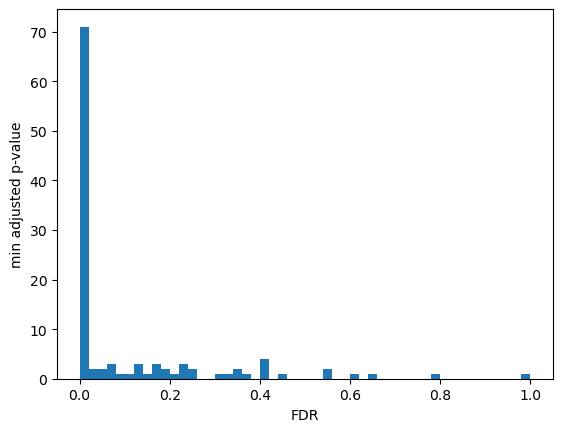

In [44]:
# compute minimum FDR for each ligand across all cell types
minLigandFDR = ligandsDE[['gene', 'fdr']].groupby('gene').min()
plt.hist(minLigandFDR['fdr'], bins=50)
plt.xlabel('FDR')
plt.ylabel('min adjusted p-value')

In [45]:
minLigandFDR.sort_values(by='fdr')

,fdr
gene,
Cp,1.000000e-240
Tnc,5.557957e-188
Pdgfd,8.281554e-105
Adam12,3.489547e-102
Nrg1,3.112635e-100
...,...
Ccl24,5.477796e-01
Tnf,6.101970e-01
Il1f9,6.502555e-01


In [46]:
sigLigands = list(minLigandFDR.loc[minLigandFDR['fdr'] < 0.05].index)
print(f'{len(sigLigands)} out of {len(ligands)} are significantly DE')

75 out of 111 are significantly DE


In [47]:
keepInteractions = interactions['ligand'].isin(sigLigands)
print(f'Keeping {sum(keepInteractions)} out of {interactions.shape[0]} interactions')

Keeping 122 out of 174 interactions


In [48]:
interactions = interactions.loc[keepInteractions]

__The plots below show DE genes within each cell type. Positive log2FC means the genes are up in condition1__

ycol: fdr
Wrote ../MCAK-iso//MAST_between_conditions/figures/MCAKiso_vs_iso_Malignant.png


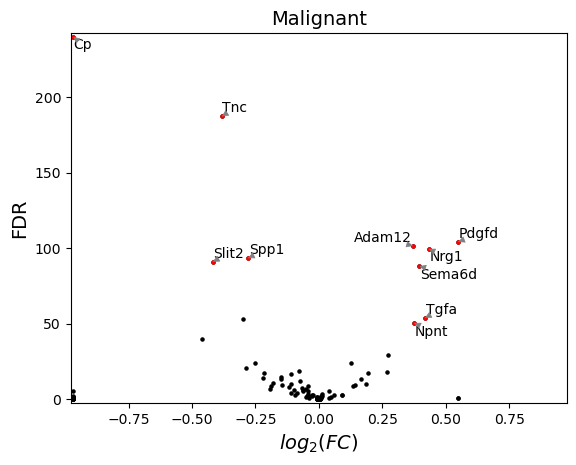

ycol: fdr
Wrote ../MCAK-iso//MAST_between_conditions/figures/MCAKiso_vs_iso_Myeloid.png


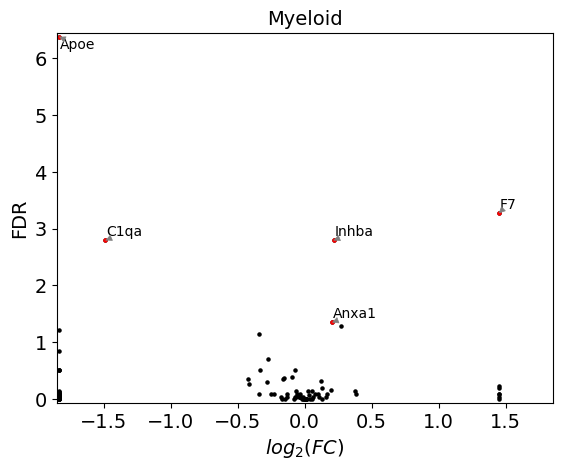

ycol: fdr
Wrote ../MCAK-iso//MAST_between_conditions/figures/MCAKiso_vs_iso_Endothelial.png


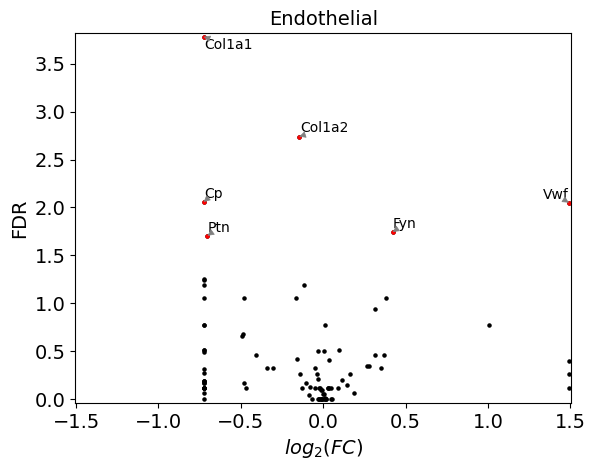

ycol: fdr
Wrote ../MCAK-iso//MAST_between_conditions/figures/MCAKiso_vs_iso_Fibroblasts.png


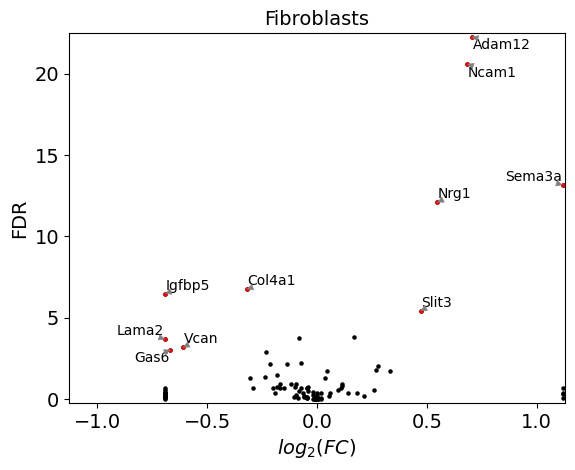

In [49]:
for cellType in ligand_cellTypes:
    # note: this function can take awhile if max_num_label is big
    ct.make_volcano_plot(ligandsDE.loc[ligandsDE['cell type'] == cellType], title=cellType, ycol='fdr', label_col='gene',
                         fontsize=10, ylabel='FDR', max_num_label=10,
                         plot_outfile=f'{mast_outdir}/figures/{condition1}_vs_{condition2}_{cellType}.png')

## Run interaction test on receptors associated with DE ligands

This is computationally quite expensive, it can take many minutes per receptor, per cell type. Run-time and memory usage increases with the number of cells. If you use too many cores you may run out of memory and jobs will crash. Some ways to reduce runtime, which are implemented in this notebook, include:
- Only run on cell types / receptors of interest
- Only run on receptors with expression levels above some threshold
- Only run on receptors associated with DE ligands
- Assess interaction effect only in HVGs rather than across genes

In [50]:
# List of cell types that you want to assess interaction effect in
# not necessarily all cell types are of interest
receptor_cellTypes = set(adata.obs["cell type"])
receptor_cellTypes

{'Endothelial', 'Fibroblasts', 'Malignant', 'Myeloid'}

In [51]:
# receptors to run on; alternatively, set this to a list of interesting receptors
interaction_receptors = list(interactions['receptor'].unique())
print(f'Num receptors = {len(interaction_receptors)}')

Num receptors = 65


In [52]:
# use this if not reducing to hvgs
keepGenes=list(adata.var.index)

In [53]:
len(keepGenes)

2000

In [54]:
adata.obs['sample'] = adata.obs['orig.ident']


### To test only on HVGs, reduce to HVGs

To test all genes (as done in CIN-TME paper), skip this section. But reducing to HVGs provides substantial computational speedup.

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/ubuntu/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/ubuntu/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_h

Found 449 highly variable genes


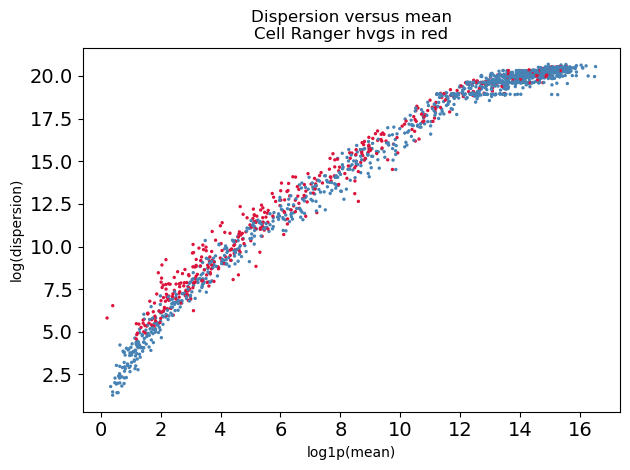

In [55]:
# This code computes HVGs, if they are not already annotated. Other methods are also possible

# This is inverse function to get original adata.layers['X'], if necessary
adata.layers['X'] = 10.0**(adata.layers['logX'] + np.log10(0.1)) - 0.1
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='sample', n_bins=20, max_mean=np.inf, layer='X')
boolean_to_color = {True:'crimson',False:'steelblue'}
colors_cell_ranger = [boolean_to_color[True] if x >0 else boolean_to_color[False]
                      for x in adata.var['highly_variable']]
plt.scatter(np.log1p(adata.var['means']), np.log(adata.var['dispersions']),
            s=2, c=colors_cell_ranger)
plt.xlabel('log1p(mean)')
plt.ylabel('log(dispersion)')
plt.title('Dispersion versus mean\nCell Ranger hvgs in red')
print(f'Found {sum(adata.var["highly_variable"])} highly variable genes')
fn = output_dir + '/hvgs_scanpy_cellranger_20bins_nomax.png'
plt.tight_layout()
plt.savefig(fn, dpi=400)
plt.show()
plt.close()

In [56]:
keepGenes = list(adata.var.loc[adata.var['highly_variable']].index)
len(keepGenes)

449

In [57]:
# targets is ligands + receptors
targets = list(set(interactions['receptor']).union(set(interactions['ligand'])))

In [58]:
# a few ligands/receptors may not be highly variable but we need to keep them as well
print(f'Keeping {len(keepGenes)} HVGs as well as {len(set(targets).difference(set(keepGenes)))} ligands/receptors that are not HVGs')
keepGenes = list(set(targets).union(set(keepGenes)))

Keeping 449 HVGs as well as 99 ligands/receptors that are not HVGs


### Run interaction tests

This is the slowest part of the analysis, this section could take many days, depending on number of receptors/ cell types and size of data set, and the computational resource (# of CPUs and memory available).

The commands will be written to a script, and the script executed outside the notebook using GNU parallel

In [59]:
# split adata by cellType, compute fraction of cells expressing each gene per cell type, and write adata object to file
# do for all cell types (not just receptor) because will use later
all_fracExp = []
adata_cellTypes = {}
for cellType in adata.obs['cell type'].unique():
    adata_cellTypes[cellType] = adata[adata.obs['cell type'] == cellType, keepGenes].copy()
    adata_cellTypes[cellType].var['fracExp'] = np.sum(adata_cellTypes[cellType].layers['logX'] > 0, axis=0)/adata_cellTypes[cellType].shape[0]
    if cellType in receptor_cellTypes:
        all_fracExp += list(adata_cellTypes[cellType].var.loc[interaction_receptors, 'fracExp'])
        adata_cellTypes[cellType].write(f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad')

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categoric

__Choose cutoff for receptor expression__

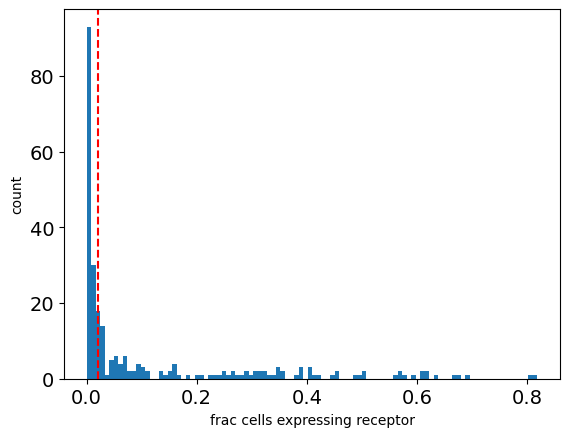

In [60]:
# look at distribution of fraction cells expressing receptors; may use this to choose cutoff for fracExp
fracExp_cutoff = 0.02
plt.hist(all_fracExp, bins=100)
plt.axvline(fracExp_cutoff, color='red', linestyle='--')
plt.xlabel('frac cells expressing receptor')
plt.ylabel('count')
plt.show()

In [61]:
for cellType in receptor_cellTypes:
    skipping = adata_cellTypes[cellType].var.loc[interaction_receptors,'fracExp'] < fracExp_cutoff
    print(f'{cellType}: Skipping {sum(skipping)} receptors with fracExp < {fracExp_cutoff:0.2f}, {sum(~skipping)} receptors remaining')

Endothelial: Skipping 25 receptors with fracExp < 0.02, 40 receptors remaining
Malignant: Skipping 39 receptors with fracExp < 0.02, 26 receptors remaining
Fibroblasts: Skipping 22 receptors with fracExp < 0.02, 43 receptors remaining
Myeloid: Skipping 44 receptors with fracExp < 0.02, 21 receptors remaining


In [62]:
interaction_outdir=f'{output_dir}/interaction_test'
!mkdir -p {interaction_outdir}

__Write commands to run.__

As in the MAST analysis of ligands, covariates can be added to the command below, by adding any column of anndata's .obs matrix to the `--covariates` option below. They should be comma-delimited, i.e., to add scrublet score, change to `--covariates cngeneson,scrublet`

We had a reviewer suggest doublet score as a covariate, adding this did not hurt but also didn't change results. It does not seem to increase run-time to add covariates, so any covariate that may influence gene expression levels may be sensible to add, any column in adata.obs can be included (though it should have a name without spaces or strange characters).  Note that if each sample is from a single condition, then sample is not an appropriate covariate, since the it will be impossible to disentangle the condition effect from the sample effect.

#### Generate command file

In [63]:
# This nay take several minutes to run, depending on number of cell types/receptors.
# It checks expression of each receptor in each condition to make sure there is sufficient data.

# set force to True to run all tests, otherwise only run genes if output file does not already exist
force=False
command_file = open(f'{interaction_outdir}/commands.sh', 'w')
expected_files = set()
num_commands=0
for cellType in receptor_cellTypes:
    curr_adata = adata_cellTypes[cellType]
    keep_receptors = curr_adata.var.loc[interaction_receptors,'fracExp'] >= fracExp_cutoff
    genes = list(keep_receptors.loc[keep_receptors].index)

    outdir=f'{interaction_outdir}/{cellType}'
    !mkdir -p {outdir}
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    
    curr_logX = curr_adata.layers['logX']
    fcond1 = np.array(curr_adata.obs['condition'] == condition1)
    fcond2 = np.array(curr_adata.obs['condition'] == condition2)
    for gene in genes:
        output_file = f'{interaction_outdir}/{cellType}/{gene}/interaction_{condition1}_vs_{condition2}.txt'
        
        # check to see if we have data to analyze this gene.
        # we require at least two cells expressing the receptor and two not expressing
        # Additionally, there should be at least one cell expressing and non-expressing for each condition
        geneidx = np.where(curr_adata.var.index == gene)[0]
        fexp = np.array(curr_logX[:,geneidx] > 0).flatten()
        if sum(fexp) < 2:
            continue
        if sum(~fexp) < 2:
            continue
        if (sum(fexp & fcond1) == 0):
            continue
        if (sum(fexp & fcond2)==0):
            continue
        if (sum((~fexp) & fcond1) == 0):
            continue
        if (sum((~fexp) & fcond2) == 0):
            continue
        expected_files.add(output_file)
        if force==False and os.path.exists(output_file):
            continue
        
        cmd=f'mkdir -p {outdir}/{gene} && {Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{interaction_outdir}/{cellType}"'
        cmd += f' --conditions "{condition1}" "{condition2}"'
        cmd += f' --covariates cngeneson --numcore 1 --genes "{gene}"'
        if force:
            cmd += f' --force'
        cmd += f' < {tutorial_dir}/R/MAST-interactionTest.R &> {outdir}/{gene}/stdout.txt\n'
        command_file.write(cmd)
        num_commands = num_commands+1
command_file.close()
print(f'Wrote command file {interaction_outdir}/commands.sh with {num_commands} commands')

Wrote command file ../MCAK-iso//interaction_test/commands.sh with 127 commands


In [64]:
# This is total number of interaction tests we need to run
len(expected_files)

127

__Set the jobs running, using parallel command__

In this cell below, `-j 10` specifies the number of simultaneous jobs to run. Each job uses a single core (as indicated by the --numcore 1 option used above; the MAST run can be parallelized, but most efficient is to run each job on a single core, and run many jobs simultaneously).

I recommend first executing the following cell with '-j 1' (one job only) and then using 'top' in a terminal to determine how much memory the job uses. Then, depending on how many cores and how much memory is available on your machine, you can kill the job (using code below, under the comment HERE IS CODE TO KILL ALL JOBS). Then restart with a number of jobs that your machine can handle.

For example, if one job takes 10 Gb of memory, and your machine has 256 Gb memory available, you should be able to use -j 25, or maybe -j 24 to leave some wiggle room. However, if your machine only has 10 cores, then you will need to use -j 10.

Note that the amount of memory required is proportional to both the number of cells in the data set, and the number of genes being analyzed. So if there are multiple cell types in receptor_cellTypes (each with a different number of cells), you should test the memory usage on a job from the biggest cell type. Or, you can split the jobs up by cell type, and use different levels of parallelization depending on the memory requirements for each.

In [65]:
ct.run_in_background(f'parallel -j 5 < {interaction_outdir}/commands.sh', 
                     stdoutfile=f'{interaction_outdir}/commands_stdout.txt')

calling bash -c 'parallel -j 5 < ../MCAK-iso//interaction_test/commands.sh' > ../MCAK-iso//interaction_test/commands_stdout.txt 2>&1 &



Once jobs have started, you can use the command below to check how many have finished.

In [70]:
# check progress of jobs.
numdone=0
for f in expected_files:
    if os.path.exists(f):
        numdone=numdone+1
print(f'Done {numdone} out of {len(expected_files)} interaction tests')

Done 127 out of 127 interaction tests


It is recommend to run 'top' on the server to see how memory and CPU usage is doing.

If you are overrunning resources, some jobs may crash and need to be restarted, or you may need to kill all processes (using the code block below). If your jobs don't all finish on the first pass, you can go back up to the 'Generate command file' cell above, make sure to set `force=False`, and it will generate a new commands file containing only the jobs that haven't completed yet. You can then repeat this process until all jobs have finished.

In [71]:
# HERE IS CODE TO KILL ALL JOBS, in case you are overrunning memory or something
# (Note this will kill any R job or parallel command running, but only within the docker container)
subprocess.run(["killall", "parallel"])
subprocess.run(["killall", "/usr/local/lib/R/bin/exec/R"])

parallel: no process found
/usr/local/lib/R/bin/exec/R: No such file or directory


CompletedProcess(args=['killall', '/usr/local/lib/R/bin/exec/R'], returncode=1)

__When all jobs finished, you may clean up temporary adata files__

In [72]:
for cellType in receptor_cellTypes:
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    print(f'Deleting {mast_infile}')
    os.system('rm -f {mast_infile}')

Deleting ../MCAK-iso//tmp/NOBACKUP/adata_Endothelial_inttest.h5ad
Deleting ../MCAK-iso//tmp/NOBACKUP/adata_Malignant_inttest.h5ad
Deleting ../MCAK-iso//tmp/NOBACKUP/adata_Fibroblasts_inttest.h5ad
Deleting ../MCAK-iso//tmp/NOBACKUP/adata_Myeloid_inttest.h5ad


## Read in interaction test results

Need to wait for all interaction tests to finish before coming to this section

In [73]:
inttest = f'interaction_{condition1}_vs_{condition2}'

In [74]:
# the function is I/O intensive so you may not want to use too many cores
ncore=10
deg = ct.read_all_contactTracing_results(receptor_cellTypes, interaction_receptors, interaction_outdir, 
                                         cond1=condition1, cond2=condition2,
                                         inttest=inttest, ncore=ncore, genes=keepGenes)
deg

Done reading files, 127 found of 260 combinations. concatenating.
Done


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


AnnData object with n_obs × n_vars = 127 × 548
    obs: 'cell type', 'receptor'
    layers: 'coef_MCAKiso_cluster', 'coef_iso', 'coef_cluster', 'pval', 'fdr.i1'

In [75]:
deg.write_h5ad("degree_save.h5ad")

The 'deg' object is an AnnData structure, where each row is a cell_type/receptor combination, 
there is a column for each gene tested for transcriptional response. The layers returned are:
- coef_{condition1}\_cluster: the logFC applied to cells in the condition1/receptor_on category. This is the 'interaction_coefficient'. In this case the column name is coef_highCIN_cluster.
- coef_{condition2}: the logFC applied to cells in the lowCIN categories (receptor on or off). In this case the column name is coef_lowCIN
- coef_cluster: the logFC applied to cells in the receptor_on category (both conditions)
- pval: The p-value describing the significance of the interaction coefficient
- fdr.i1: FDR-corrected p-value. FDR correction is done independently across each row.

In [63]:
deg

AnnData object with n_obs × n_vars = 1255 × 4741
    obs: 'cell type', 'receptor'
    layers: 'coef_BRAIN_METS_cluster', 'coef_PRIMARY', 'coef_cluster', 'pval', 'fdr.i1'

In [66]:
# compute number of significant interactions for each row
deg.obs['numSigI1_fdr05'] = np.sum(deg.layers['fdr.i1'] < 0.05, axis=1)

In [67]:
deg.obs

,cell type,receptor,numSigI1_fdr05
0,Tcells,FPR2,56
1,Tcells,SORL1,410
2,Tcells,TNFRSF21,441
3,Tcells,CD74,69
4,Tcells,ENTPD1,111
...,...,...,...
1250,Endothelial,NLGN2,0
1251,Endothelial,NLGN4X,0
1252,Endothelial,NLGN4Y,138
1253,Endothelial,NPFFR1,1


## Generate a ranked list of interactions

This is one possibly way to rank interactions - of all the interactions with a differentially expressed ligand, rank by size of interaction effect (numSigI1_fdr05)

In [68]:
ligands = ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'ligand',
                                                                           'cell type':'cell_type_ligand'})

In [69]:
# some ligands have log2FC=NA but they are not significant (check)
ligands.loc[pd.isna(ligands['log2FC']),'fdr'].unique()

array([1.])

In [70]:
# they all have FDR of 1 so just set log2FC to 0
ligands.loc[pd.isna(ligands['log2FC']),'log2FC'] = 0

In [71]:
ligands['ligandDE'] = ligands['fdr'] < 0.05

In [72]:
receptors = deg.obs.rename(columns={'cell type':'cell_type_receptor'})

In [73]:
ranked_interactions = interactions.merge(ligands, on='ligand').merge(receptors, on='receptor').sort_values(
    by=['ligandDE', 'numSigI1_fdr05'], ascending=False)[['ligand', 'cell_type_ligand', 'receptor', 'cell_type_receptor',
                                                         'log2FC', 'fdr', 'ligandDE', 'numSigI1_fdr05']].rename(
    columns={'log2FC':'log2FC_ligand', 'fdr':'fdr_ligand', 'numSigI1_fdr05':'numSigI1_fdr05_receptor'})
ranked_interactions.to_csv(f'{output_dir}/ranked_interactions.txt', index=False, sep='\t')
print(f'Wrote ranked interaction list to {output_dir}/ranked_interactions.txt')

Wrote ranked interaction list to ../Pri_BM//ranked_interactions.txt


In [74]:
# Here are top 5
ranked_interactions.iloc[:5]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
2444,CADM1,Cancercells,CADM1,Cancercells,-0.355564,1.000000e-240,True,3791
2452,CADM1,Endothelial,CADM1,Cancercells,0.525918,3.852057e-32,True,3791
2460,CADM1,CAFs,CADM1,Cancercells,-0.285122,2.030947e-58,True,3791
2468,CADM1,Dedifferentiatedcells,CADM1,Cancercells,0.220896,1.333959e-18,True,3791
2476,CADM1,Tcells,CADM1,Cancercells,-0.030917,3.542174e-02,True,3791


In [84]:
deg.shape

(1255, 4741)

You can also make a list of ranked interactions integrated over ligand cell type, for example, require ligand DE in one cell type

Here, the values of ligand cell type, log2FC, and fdr are all for the ligand cell type with minimum fdr value

In [76]:
ranked_interactions2 = ranked_interactions.loc[ranked_interactions.drop(columns='cell_type_ligand').groupby(
    ['ligand', 'receptor', 'cell_type_receptor']).idxmin()['fdr_ligand']].sort_values(
    by=['ligandDE', 'numSigI1_fdr05_receptor'], ascending=False)
ranked_interactions2.to_csv(f'{output_dir}/ranked_interactions_across_ligand_cell_type.txt', index=False, sep='\t')
print('Wrote ranked interaction list (integrated over ligand cell type) to {output_dir}/ranked_interactions_across_ligand_cell_type.txt')

/tmp/ipykernel_328017/2076028802.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ranked_interactions2 = ranked_interactions.loc[ranked_interactions.drop(columns='cell_type_ligand').groupby(


KeyError: '[nan] not in index'

In [ ]:
ranked_interactions2.iloc[:5]

## Explore downstream interaction effects

We can use the coef estimates in the deg structure, along with p-values, to explore downstream effects.

### Optional: fix NA coefficients

A substantial number of logFC estimates coming from MAST are recorded as NA, even when the p-value is significant. I believe this is because the MAST estimate is hitting +/- infinity, or passing some internal boundaries set by MAST. In this section we can replace the NAs with a rough estimate based on mean # of expressed cells in different categories.

Note: this section can be time-consuming, and is not necessary unless you want to explore the transcriptional response to a particular ligand-receptor interaction

__First, how many of these NAs are there?__

In [ ]:
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
coef_layers = [x for x in deg.layers.keys() if x.startswith('coef') and not x.endswith('_est')] 
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

In [ ]:
# Here is code that creates the estimates - for each coefficient in deg.layers, it addes another layer with the suffix _est that gives
# the rough estimated values

# Note- it will distribute each row of deg across the cores specified by ncores, in chunks of size chunksize.
# I have found it is much faster to use big chunks.
ct.estimate_contactTracing_coefs(deg, adata, condition1, condition2, ncores=5, chunksize=50)



In [ ]:
# plot MAST estimates vs rough estimates - they should fall along the diagonal, with a good deal of noise.
# (MAST model is much more sophisticated).
#log_factor = np.log10(2)
for layer in coef_layers:
    if f'{layer}_est' in deg.layers:
        plt.subplots(figsize=(4,4))
        plt.scatter(np.array(deg.layers[layer]).reshape(-1), 
                    np.array(deg.layers[f'{layer}_est']).reshape(-1), color='black', s=10, alpha=0.1)
        plt.gca().axline((1,1), slope=1, ls='--', color='gray')
        plt.xlabel(layer)
        plt.ylabel(f'{layer}_est')
        plt.show()

__If you want to replace NAs with estimated values, do:__

In [ ]:
for layer in coef_layers:
    f = np.isnan(deg.layers[layer])
    deg.layers[layer][f] = deg.layers[f'{layer}_est'][f]

In [ ]:
# confirm there are no more NAs
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

### Example plot showing interaction effect for single receptor in one cell type


The plot shows the log-fold coefficient for genes when the receptors is on, in each of the two conditions.

The color of the dot shows the size of the 'interaction effect'. The size of the dot shows the significance (-log10 pvalue).

Points falling along the diagonal show the same effect in both conditions, as you move away from the diagonal you can see genes that are affected differently.

In [94]:
# change next two lines to cellType / gene of interest
cellType = 'B-cells'
gene = 'DAG1'
numLabel=20

#cellType='PMN_gMDSC'
#gene='Cd74'

idx = np.where((deg.obs['cell type'] == cellType) & (deg.obs['receptor'] == gene))[0][0]

pvals = deg.layers['pval'][idx,:].reshape(-1)
cond1On = (deg.layers[f'coef_{condition1}_cluster'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)
cond2On = (deg.layers[f'coef_{condition2}'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)

# color by interaction effect
cvals = deg.layers[f'coef_{condition1}_cluster'][idx,:].reshape(-1)

# size by p-value
svals = -np.log10(pvals)
# 150 just gives reasonable size dot, can adjust as needed
svals = svals * 150/np.max(svals)


nanvals = (np.isnan(cond1On)) | (np.isnan(cond2On))
f = (pvals < 1) & (~nanvals)
if sum(nanvals) > 0:
    print(f'Skipping {sum(nanvals)} points with NAN coefs and p-val < 1, plotting {sum(f)} genes')

order = np.argsort(svals[f])

tmpdf = pd.DataFrame({'xvals':cond2On[f][order],
                      'yvals':cond1On[f][order],
                      'gene':deg.var.index[f][order],
                      'color':cvals[f][order],
                      's':svals[f][order]})


plt.scatter(tmpdf['xvals'], tmpdf['yvals'], 
            c=tmpdf['color'], s=tmpdf['s'],
            edgecolors=ct.makeTransparent('gray', alpha=0.5),
            cmap=plt.cm.RdBu_r, vmin=-0.3, vmax=0.3, alpha=0.9)

tmpdf = tmpdf.sort_values(by='s', ascending=False).reset_index(drop=True)

# add text labels to most significant genes
use_numLabel = numLabel
if use_numLabel > sum(f):
    use_numLabel = sum(f)

texts = []
for i in tmpdf.iloc[:use_numLabel].index:
    texts.append(plt.text(tmpdf.loc[i,'xvals'], tmpdf.loc[i,'yvals'], tmpdf.loc[i,'gene'], fontsize=10))
niter = adjust_text(texts, 
                    x=list(tmpdf['xvals']), 
                    y=list(tmpdf['yvals']), 
                    #avoid_self=True, force_text=(2,2),
                    #force_pull=(0.001,0.001),
                    expand_points=(1.1, 1.1),
                    expand_text=(1.1,1.1),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
plt.xlabel(f'{condition2} {gene}=on coefficient')
plt.ylabel(f'{condition1} {gene}=on coefficient')
maxval = np.max(np.abs(list(cond2On[f])+list(cond1On[f])))*1.1
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
linelist=[]
linelist += plt.plot([-maxval, maxval], [0,0], c='lightgray', linestyle='dashed')
linelist += plt.plot([0,0], [-maxval, maxval], c='lightgray', linestyle='dashed')
plt.title(cellType + ' ' + gene)


IndexError: index 0 is out of bounds for axis 0 with size 0

## Run cluster test on all ligands/receptors and compute differential components

This is done in preparation of making the circos plot, we use diffusion components to create an ordering of ligands/receptors around the circle

In the CIN/TME paper, this was the 'cluster' test, run in MAST. We are testing for genes that are differentially expressed when the target gene is on vs off, for every target. But it is very slow to do in MAST and only used for visualization so it makes more sense to use a faster algorithm. Using scanpy here. It still takes awhile, but hopefully minutes to an hour or so, rather than days.

In [85]:
adata

AnnData object with n_obs × n_vars = 68413 × 35992
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'patient_long', 'patient', 'predicted_doublets', 'doublet_scores', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_iced_main', 'celltype_iced_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'celltype_mid_main', 'celltype_mid_fine', 'tumor_nontumor_minor', 'integrated_snn_res.0.5', 'STK11mutvsNonSTK11mut', 'PRIMARYvsBRAIN_METSvsCHEST_WALL_MET', 'condition', 'cell type', 'cngeneson', 'sample'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'logX', 'X'

In [86]:
cellTypes = adata.obs['cell type'].unique()
cellTypes

['Cancercells', 'Endothelial', 'CAFs', 'Dedifferentiatedcells', 'Tcells', 'CNS', 'Myeloid', 'Bcells']
Categories (8, object): ['Bcells', 'CAFs', 'CNS', 'Cancercells', 'Dedifferentiatedcells', 'Endothelial', 'Myeloid', 'Tcells']

In [87]:
sig_receptors = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
sig_receptors.shape

(1046, 3)

In [88]:
# Create object to hold differential expression results
# It is an anndata structure with rows for every target gene and cell type we are interested in
# and columns for every gene

# The targets we are interested in are receptors with some minimum number of interaction effects,
# and ligands associated with these receptors.

minInteractions=1

receptor_df = deg.obs.loc[deg.obs['numSigI1_fdr05'] >= minInteractions][['cell type', 'receptor']].rename(columns={'receptor':'target'})
ligand_df = pd.DataFrame(product(ligand_cellTypes, 
                                 interactions.loc[interactions['receptor'].isin(receptor_df['target']), 'ligand']),
                         columns=['cell type', 'target'])
targets_df = pd.concat([receptor_df, ligand_df])
targets_df = targets_df[~targets_df.duplicated()].sort_values(by=['cell type', 'target']).reset_index(drop=True)
targets_df.index = targets_df.index.map(str)
diffComp = sc.AnnData(X=np.empty(shape=(targets_df.shape[0], deg.var.shape[0]), dtype=np.float32),
                      obs=targets_df, var=deg.var)
diffComp

AnnData object with n_obs × n_vars = 3547 × 4741
    obs: 'cell type', 'target'

In [89]:
# add layers for all the DE statistics
diffComp.layers['pval'] = diffComp.X.copy()
diffComp.layers['fdr'] = diffComp.X.copy()
diffComp.layers['lfc'] = diffComp.X.copy()
diffComp.layers['score'] = diffComp.X.copy()

In [90]:
def de_score(targetCellType):
    (target, cellType) = targetCellType
    adata = adata_cellTypes[cellType]
    idx = np.where(adata.var.index == target)[0]
    isExpressed = np.reshape(adata.layers['logX'][:,idx] > 0, -1)
    tmpcol = f'{target}_cluster'
    adata.obs[tmpcol] = pd.Categorical(['expressed' if x else 'not' for x in isExpressed], categories=['expressed', 'not'])
    if (sum(adata.obs[tmpcol].value_counts() <=1) > 0):
        # cannot compute if we don't have more than one cell in both categories...skip
        adata.obs.drop(columns=tmpcol, inplace=True)
        return (target, cellType, 0)
    newkey=f'rank_genes_groups_{target}'
    sc.tl.rank_genes_groups(adata, groupby=tmpcol, layer='logX', method='wilcoxon', groups=['expressed'], key_added=newkey)
    adata.obs.drop(columns=tmpcol, inplace=True)
    tmprg = adata.uns[newkey]
    pvals = np.array([x[0] for x in tmprg['pvals']])
    minPval = np.min(pvals[pvals > 0])
    pvals[pvals==0] = minPval
    scores = np.array([x[0] for x in tmprg['scores']])
    fdr = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')[1]
    tmpdf = pd.DataFrame({'gene':[x[0] for x in tmprg['names']],
                          'pval':pvals,
                          'fdr':fdr,
                          'lfc':[x[0] for x in tmprg['logfoldchanges']],
                         'score':scores}).set_index('gene')
    tmpdf['score'] =  -np.log10(tmpdf['pval'])*tmpdf['lfc']
    adata.uns.pop(newkey)
    return (target,cellType,tmpdf)
    #return -np.log10(tmpdf['pval'])*tmpdf['lfc']

The following cell loops through all cell types, all ligands/receptors, and performs a test for differential expression across
all genes, for whehter gene expression is related to whether the ligand/receptor is expressed. It is all done
within the given cell type. In the end, `diffComp` is an adata object where:
- each row is a ligand or a receptor in a particular cell type
- each column is a gene (same columns as adata)
- there are matrices .layers['lfc'], .layers['pval'], .layers['fdr'], and .layers['score'] with results from rank_genes_groups function ('wilcoxan' method).

In [91]:
# set this to the number of jobs you want to run simultaneously
num_processes=20
targetlist = [(diffComp.obs.loc[x, 'target'], diffComp.obs.loc[x, 'cell type']) for x in diffComp.obs.index]
numjob=diffComp.shape[0]
numdone=0
fracReport=0.1
nextfrac=0.1
print(f'Running LRT tests for all ligands/receptors')
with multiprocessing.Pool(processes=num_processes) as p:
    func = partial(de_score)
    for tmp in p.imap_unordered(func, targetlist, chunksize=50):
        target = tmp[0]
        cellType=tmp[1]
        idx = np.where((diffComp.obs['target'] == target) & (diffComp.obs['cell type'] == cellType))[0][0]
        if type(tmp[2]) == int:
            diffComp.layers['pval'][idx,:] = 1
            diffComp.layers['fdr'][idx,:] = 1
            diffComp.layers['lfc'][idx,:] = 0
            diffComp.layers['score'][idx,:] = 0
        else:
            for layer in ['pval', 'fdr', 'lfc', 'score']:
                diffComp.layers[layer][idx,:] = np.array(tmp[2].loc[diffComp.var.index, layer]).reshape(-1)
        numdone=numdone+1
        if numdone/numjob > nextfrac:
            print(f'Done {numdone} out of {numjob} LRT tests ({numdone/numjob*100:.1f}% done)')
            nextfrac = nextfrac + fracReport

Running LRT tests for all ligands/receptors


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 355 out of 3547 LRT tests (10.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 710 out of 3547 LRT tests (20.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 1065 out of 3547 LRT tests (30.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 1419 out of 3547 LRT tests (40.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 1774 out of 3547 LRT tests (50.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 2129 out of 3547 LRT tests (60.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 2483 out of 3547 LRT tests (70.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 2838 out of 3547 LRT tests (80.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 3193 out of 3547 LRT tests (90.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction

Done 3547 out of 3547 LRT tests (100.0% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invali

Done 691 out of 767 LRT tests (90.1% done)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Done 767 out of 767 LRT tests (100.0% done)


__If the code above fails, here is a non-parallelized version to try__

Otherwise skip the following cell

In [95]:
# This cell is optional alternative to previous cell. Set previousCellFailed=True to run
previousCellFailed=False
if previousCellFailed:
    numdone=0
    fracReport=0.1
    nextfrac=0.1
    maxidx = diffComp.obs.shape[0]
    for idx in range(maxidx):
        cellType = diffComp.obs.iloc[idx]['cell type']
        target = diffComp.obs.iloc[idx]['target']
        tmp = de_score((target, cellType))
        if type(tmp[2]) == int:
            diffComp.layers['pval'][idx,:] = 1
            diffComp.layers['fdr'][idx,:] = 1
            diffComp.layers['lfc'][idx,:] = 0
            diffComp.layers['score'][idx,:] = 0
        else:
            for layer in ['pval', 'fdr', 'lfc', 'score']:
                diffComp.layers[layer][idx,:] = np.array(tmp[2].loc[diffComp.var.index, layer]).reshape(-1)
        numdone=numdone+1
        if numdone/numjob > nextfrac:
            print(f'Done {numdone} out of {numjob} LRT tests ({numdone/numjob*100:.1f}% done)')
            nextfrac = nextfrac + fracReport

In [92]:
diffComp.obs['fracExp'] = -1
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    diffComp.obs.loc[i,'fracExp'] = adata_cellTypes[cellType].var.loc[target,'fracExp']

/tmp/ipykernel_328017/4227478235.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00042625745950554135' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diffComp.obs.loc[i,'fracExp'] = adata_cellTypes[cellType].var.loc[target,'fracExp']


In [93]:
# set score to zero when testing gene for transcriptional response to itself
idx1=0
count=0
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    if target in diffComp.var.index:
        idx2 = np.where(diffComp.var.index == target)[0][0]
        diffComp.layers['score'][idx1,idx2] = 0
        count=count+1
    idx1=idx1+1
print(f'Fixed {count} scores for DE of own gene to zero')

Fixed 3547 scores for DE of own gene to zero


In [94]:
# This took awhile to compute, so save:
diffComp.write(f'{output_dir}/diffComp.h5ad')

The DE score is -logFC * log10(p-value), plot distribution

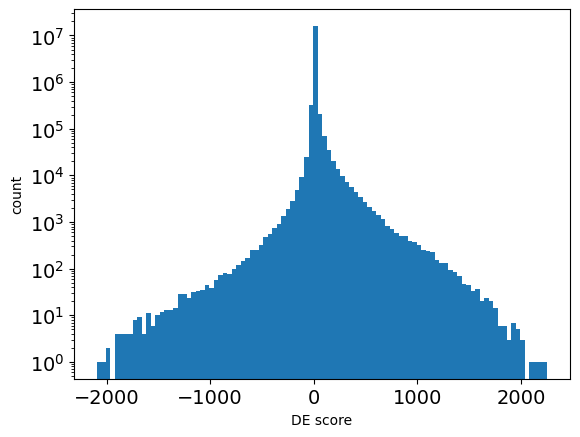

In [95]:
plt.hist(diffComp.layers['score'].reshape(-1), bins=100)
plt.xlabel('DE score')
plt.ylabel('count')
plt.yscale('log')
plt.show()

Plot distribution of FDR 

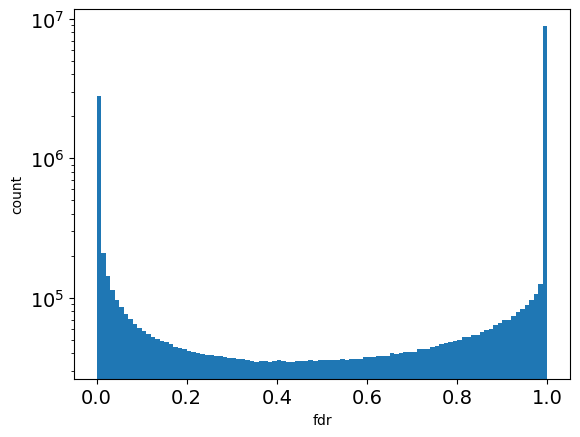

In [96]:
plt.hist(diffComp.layers['fdr'].reshape(-1), bins=100)
plt.xlabel('fdr')
plt.ylabel('count')
plt.yscale('log')
plt.show()

In [97]:
diffComp.layers['score-sig'] = diffComp.layers['score'].copy()
f = diffComp.layers['fdr'] > 0.05
diffComp.layers['score-sig'][f]= 0

Plot distribution of scores, conditional on being significant

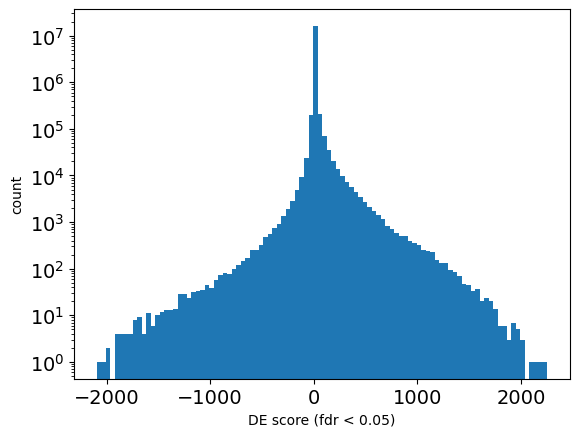

In [98]:
plt.hist(diffComp.layers['score-sig'].reshape(-1), bins=100)
plt.xlabel('DE score (fdr < 0.05)')
plt.ylabel('count')
plt.yscale('log')
plt.show()

### Compute diffusion maps

We use diffusion maps to sort genes along the circos plot, based on DE scores computed above

In [99]:
diffComp

AnnData object with n_obs × n_vars = 3547 × 4741
    obs: 'cell type', 'target', 'fracExp'
    layers: 'pval', 'fdr', 'lfc', 'score', 'score-sig'

In [100]:
diffComp.X = diffComp.layers['score']

In [101]:
#diffComp.X
diffComp.X[np.isnan(diffComp.X)]=0.0

In [102]:
cellTypes=diffComp.obs['cell type'].value_counts().index
sc.settings.verbosity = 0
diffComp.obs['cell_type_dc1'] = 0
diffComp.obs['cell_type_dc2'] = 0
!mkdir -p {output_dir}/diffusionComponents
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < 5):
        print(f'Skipping {cellType}, only {tmp.shape[0]} rows')
        continue
    init_npcs = np.min([50, tmp.shape[0]-2])
    sc.pp.pca(tmp, n_comps=init_npcs)
    if np.min(tmp.uns['pca']['variance'])==0:
        init_npcs = np.argmin(tmp.uns['pca']['variance'])
        tmp.uns['pca']['variance'] = tmp.uns['pca']['variance'][:init_npcs]
        tmp.uns['pca']['variance_ratio'] = tmp.uns['pca']['variance_ratio'][:init_npcs]
    #sc.pl.pca_variance_ratio(tmp, n_pcs=init_npcs, log=True)
    x = [x for x in range(len(tmp.uns['pca']['variance_ratio']))]
    y = np.log(tmp.uns['pca']['variance_ratio'])
    knee = KneeLocator(x=x, y=y, curve='convex', direction='decreasing', online=True, interp_method='polynomial')
    #knee.plot_knee_normalized()

    opt_n_pcs = knee.knee+1
    print('Optimal Number of PCs: ', str(opt_n_pcs))
    sc.pp.pca(tmp, n_comps=opt_n_pcs)
    #dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    #ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=15)
    dm_res = palantirFuncs.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    ms_data = palantirFuncs.determine_multiscale_space(dm_res, n_eigs=15)
    tmp.obsm['DC'] = ms_data.to_numpy()
    diffComp.obs.loc[f,'cell_type_dc1'] = tmp.obsm['DC'][:,0]
    diffComp.obs.loc[f,'cell_type_dc2'] = tmp.obsm['DC'][:,1]
    
    # get a version normalized by cell type for circos plots
    maxval = np.max(np.abs(tmp.obsm['DC'][:,0]))
    if maxval == 0:
        maxval = 1
    diffComp.obs.loc[f,'cell_type_dc1_norm'] = tmp.obsm['DC'][:,0]/maxval

Cancercells (493, 4741)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Optimal Number of PCs:  14
Determing nearest neighbor graph...


/tmp/ipykernel_328017/1787370216.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.23899676 -0.42700994 -0.68779673 -0.23161426 -1.12928493 -1.13561906
 -1.39326005 -1.19801193 -0.1644958   1.36286448  0.51018193  0.53204638
 -0.85127515 -0.32332484 -1.46507456  0.11473896 -0.23613823 -0.56438502
  1.71269944 -0.5308931   2.10932371 -1.01850948  0.4357615  -0.12061983
 -0.21574549 -0.77400106 -0.53637817  3.09325    -0.47306333 -0.50700324
  3.09280839 -0.47946963  2.97568463  2.81494498 -0.18908287  2.97904889
  0.23144829 -0.03532973  3.19803116  0.16419391 -0.52534405 -0.48624445
 -0.58164926 -0.3998869  -0.91700116 -0.489511    0.37553933 -0.4957976
  0.08965539 -0.32807969 -0.32932902  0.17896614 -1.55983695 -0.4784742
 -1.06395117 -0.88208969 -0.38011374 -0.5429118  -0.53692904 -0.54128018
 -0.48494293 -0.55955642 -0.36098372  0.56917667 -0.53608742 -0.26370105
 -0.38355778 -0.49337376 -0.53444069 -0.4

CAFs (482, 4741)
Optimal Number of PCs:  11
Determing nearest neighbor graph...
Dedifferentiatedcells (474, 4741)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Optimal Number of PCs:  9
Determing nearest neighbor graph...
CNS (470, 4741)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Optimal Number of PCs:  11
Determing nearest neighbor graph...
Tcells (447, 4741)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Optimal Number of PCs:  10
Determing nearest neighbor graph...
Endothelial (433, 4741)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Optimal Number of PCs:  7
Determing nearest neighbor graph...


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Myeloid (394, 4741)
Optimal Number of PCs:  11
Determing nearest neighbor graph...
Bcells (354, 4741)


/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Optimal Number of PCs:  12
Determing nearest neighbor graph...


__DC plots__

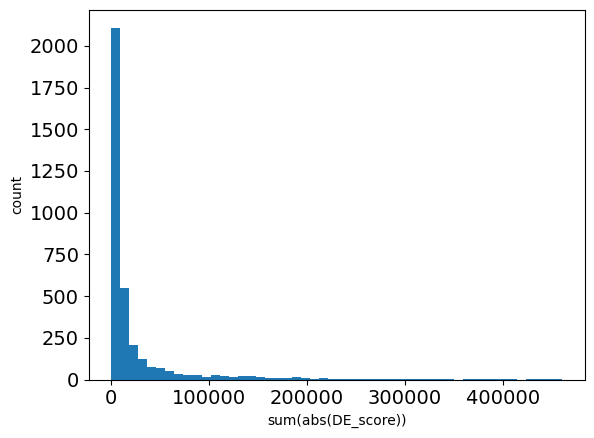

In [103]:
# size each receptor/ligand by sum of abs(DE scores) across all genes
diffComp.obs['absDE'] = np.sum(np.abs(diffComp.layers['score']), axis=1)
plt.hist(diffComp.obs['absDE'], bins=50)
plt.xlabel('sum(abs(DE_score))')
plt.ylabel('count')
diffComp.obs['absDE_scaled'] = diffComp.obs['absDE']/np.max(diffComp.obs['absDE'])

Plot diffusion components 2 vs 1 for each cell type. Shows distribution of transcriptional response.

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Cancercells (493, 4741)


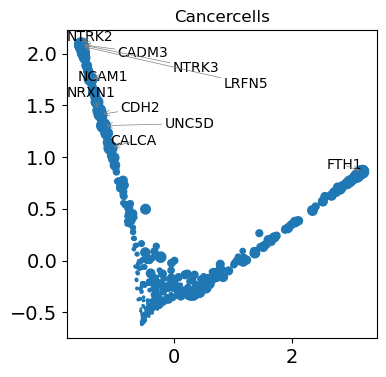

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


CAFs (482, 4741)


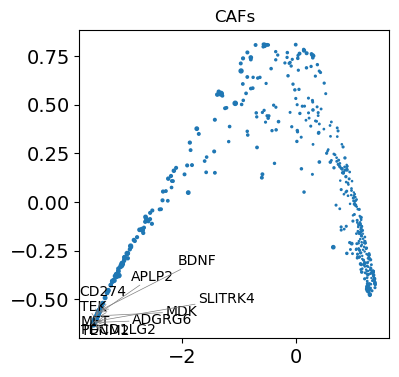

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Dedifferentiatedcells (474, 4741)


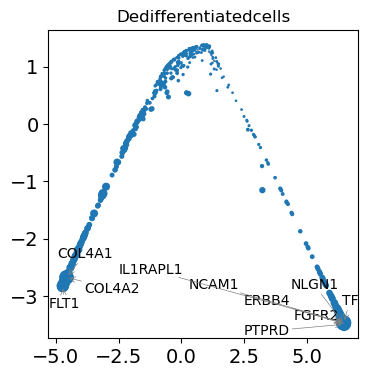

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


CNS (470, 4741)


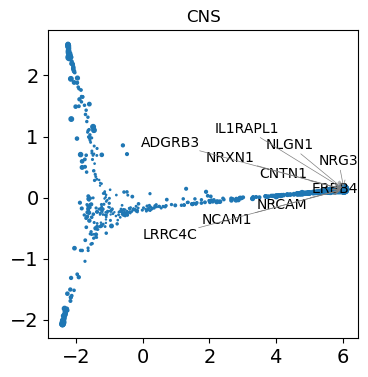

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Tcells (447, 4741)


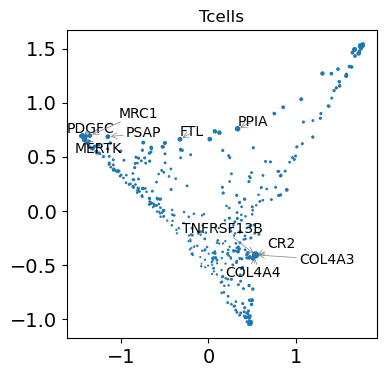

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Endothelial (433, 4741)


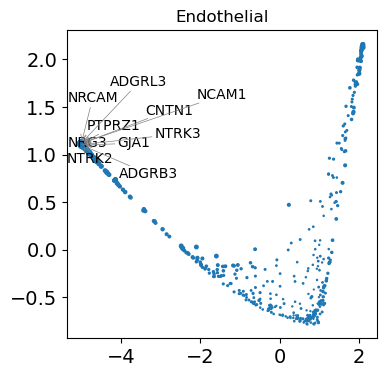

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Myeloid (394, 4741)


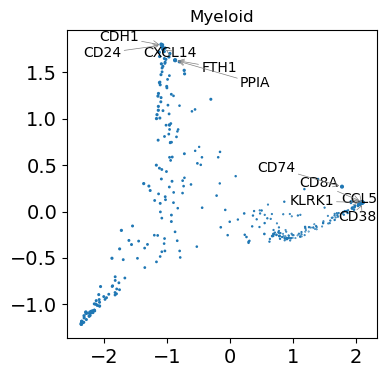

/home/ubuntu/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Bcells (354, 4741)


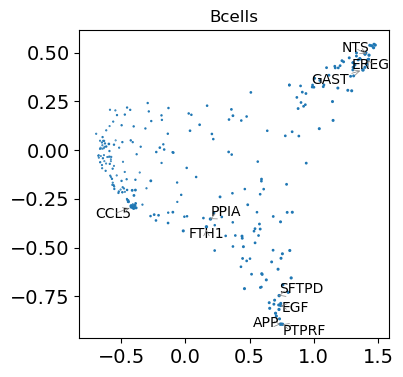

In [104]:
sc.settings.verbosity = 0
numLabel=10
sizeFactor=100  # adjust to scale poinst
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < numLabel):
        continue
    plt.subplots(figsize=(4,4))
    
    xvals = np.array(tmp.obs['cell_type_dc1'])
    yvals = np.array(tmp.obs['cell_type_dc2'])
    sizevals = np.array(tmp.obs['absDE_scaled']*sizeFactor)
    labels = np.array(tmp.obs['target'])
    plt.scatter(xvals, yvals, s=sizevals)
    plt.title(cellType)
    
    texts = []
    tmpobs = tmp.obs.sort_values(by='absDE_scaled', ascending=False).iloc[:numLabel]
    for i in tmpobs.index:
        texts.append(plt.text(tmpobs.loc[i,'cell_type_dc1'], tmpobs.loc[i,'cell_type_dc2'], tmpobs.loc[i,'target'],
                             fontsize=10))
    f = list(range(0, len(x), 50))
    niter = adjust_text(texts, 
                        x=xvals, y=yvals, 
                        #avoid_self=True, force_text=(2,2),
                        #force_pull=(0.001,0.001),
                        expand_points=(0.1,0.1),
                        expand_text=(1.1,1.1),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
    
    plt.savefig(f'{output_dir}/diffusionComponents/diffusion_components_{cellType}.png', dpi=300, bbox_inches='tight')
    plt.show()

### GSEA analysis of DCs

GSEA analysis may yield some insight about biological processes underlying the diffusion components.

A GMT file is required, they may be specialized for each cell type, the ones we use are in the tutorial data directory.

__First, for each gene and each cell type, compute the correlation between DC1 and the DE Scores,
we will use this correlation as a score to feed GSEA__

In [87]:
for cellType in diffComp.obs['cell type'].unique():
    f = (diffComp.obs['cell type'] == cellType)
    print(cellType, sum(f), sum(diffComp.obs['cell type'] == cellType))
    dc = diffComp.obs.loc[f,'cell_type_dc1']
    corrCol = f'{cellType}_dc1_corr'
    for g in diffComp.var.index:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            diffComp.var.loc[g,corrCol] = np.corrcoef(dc.to_numpy(), diffComp[f,g].X.flatten())[0,1]

NameError: name 'diffComp' is not defined

__Also, in our case, the data is from mouse but GMT files use human genes. We need a mapping from mouse to human gene names.__

Our GSEA code will use this mapping, plus the capitalized version of any mouse gene that does not appear in this mapping, if the capitalized version appears in the human gene set.

## Circos plot

First, make a data frame containing all relevant statistics about ligands and receptors
including numSigInt_fdr05 for receptors, ligand fdr and logFC, and diffusion component values (for sorting them along circle)

This should be filtered to only the ligands/receptors that should be plotted along circle

In [105]:
# combine data about ligands and receptors into one data frame

# Only keep receptors with a minimum number of interaction effects (numSigI1_fdr05 > 0)
# and ligands that interact with these receptors, and are differentially expressed (fdr < 0.05)

# a 'target' refers to a ligand or receptor, some can be both. The columns 'ligand' and 'receptor' are booleans
# set to True if the target is a ligand/receptor
degobs = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
target_stats = diffComp.obs.merge(degobs.rename(columns={'receptor':'target'}), on=['target', 'cell type'],how='outer')
target_stats['receptor'] = ~pd.isna(target_stats['numSigI1_fdr05'])
allReceptors = list(set(target_stats.loc[target_stats['receptor'], 'target']))
allLigands = list(set(interactions.loc[interactions['receptor'].isin(allReceptors),'ligand']))
target_stats['ligand'] = target_stats['target'].isin(allLigands)

target_stats = target_stats.merge(ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'target'}), 
                                  on=['target', 'cell type'], how='left')

# remove ligands that are not DE
f = (target_stats['ligand']) & (target_stats['fdr'] >= 0.05)
f1 = (f) & (target_stats['receptor'])
target_stats.loc[f1,'ligand'] = False
f2 = (f) & (~target_stats['receptor'])
target_stats = target_stats.loc[~f2].reset_index(drop=True)

f = pd.isna(target_stats['numSigI1_fdr05'])
target_stats.loc[f,'numSigI1_fdr05'] = 0


In [106]:
target_stats
target_stats.to_csv(f'{output_dir}/target_stats.csv')

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [107]:
target_stats

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,Bcells,ADM,0.016198,-0.497974,-0.157784,-0.336650,2414.514160,0.005238,0.0,False,True,0.041293,2.638306e-04
1,Bcells,ALCAM,0.369565,-0.608806,-0.035254,-0.411578,1141.567993,0.002477,0.0,False,True,-0.092898,2.741290e-04
2,Bcells,APLP2,0.028986,0.459993,-0.710939,0.310974,6779.869141,0.014709,0.0,False,True,0.097740,2.428394e-04
3,Bcells,AREG,0.041347,-0.650908,0.039371,-0.440040,1705.140381,0.003699,0.0,False,True,-0.049580,2.188748e-03
4,Bcells,ASIP,0.026854,-0.555342,-0.186397,-0.375433,1695.344971,0.003678,0.0,False,True,0.058185,2.107305e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,Tcells,WNT10A,0.002843,0.342517,-0.678364,0.194008,5870.312500,0.012736,0.0,False,True,-0.005909,9.473575e-05
2106,Tcells,WNT2B,0.111301,-0.678685,0.059609,-0.384421,2664.866699,0.005782,0.0,False,True,0.040957,1.881786e-05
2107,Tcells,WNT3,0.003838,0.528985,-0.204567,0.299627,4653.914062,0.010097,0.0,False,True,-0.011102,8.043108e-06
2108,Tcells,WNT5A,0.114428,-0.678066,0.121168,-0.384070,3818.508789,0.008284,0.0,False,True,0.117082,7.449718e-36


In [108]:
# Show counts of ligands, receptors, some genes are both
target_stats[['ligand', 'receptor']].value_counts()

ligand  receptor
True    False       1064
False   True         923
True    True         123
Name: count, dtype: int64

In [109]:
#cellType_colormap = {'B_cells': '#F9D318',
#     'Endothelial_cells': '#6B0C0C',
#     'Fibroblast_cells': '#216C04',
#     'Macrophages_mMDSC': '#0047CF',
#     'Mast_cells': '#A16E0F',
#     'NK_cells': '#EA0C0C',
#     'Osteoclasts': '#8298B0',
#     'PMN_gMDSC': '#15EAFB',
#     'T_cells': '#F47D08',
#     'Tumor_cells': '#A4D10A',
#     'cDC': '#C438FB',
#     'pDC': '#51119A'}

In [115]:
cellType_colormap = {'B_cells':'#F9D318', 'Endothelial': '#6B0C0C', 'Fibroblasts':'#216C04',
                     'Malignant': '#51119A', 'Myeloid': '#F47D08','T_cells':'#A4D10A','Other':'#51119A'}

In [116]:
def target_strats_filters(row):
    if (row["receptor"]  == "True" and abs(row["numSigI1_fdr05"]) > 5):
        return True
    elif (row["receptor"]  == "True"):
        return False
    if (abs(row["fdr"]) < 0.1):
        return True
    return False

target_stats =target_stats[ target_stats.apply(lambda x: target_strats_filters(x), axis  =1)]
target_stats


new_pairs = []
for i,x in interactions.iterrows():
    ligands = target_stats[target_stats["target"] == x["ligand"]]
    receptors = target_stats[target_stats["target"] == x["receptor"]]
    for j,y in ligands.iterrows():
        for k,z in receptors.iterrows():
            new_pairs.append([ x["ligand"], x["receptor"], y["cell type"], z["cell type"], y["log2FC"], 
                            y['fdr'], y['absDE_scaled'], z['absDE_scaled'], y['numSigI1_fdr05'], z['numSigI1_fdr05'],
                              y['cell_type_dc1'], z['cell_type_dc2']
                             ])
df = pd.DataFrame(new_pairs, columns = ["ligand", "receptor", "ligand_t", "receptor_t", "log2Fc",
                                       "fdr", "ligand de", "receptor de", "ligand numSig", "receptor numSig", "dc1", "dc2"]  )

In [117]:
df.to_csv(f'{output_dir}/target_stats_interactions.csv')
df

,ligand,receptor,ligand_t,receptor_t,log2Fc,fdr,ligand de,receptor de,ligand numSig,receptor numSig,dc1,dc2
0,CDH2,CDH2,Endothelial,Endothelial,-0.007730,7.218842e-05,0.004956,0.004956,67.0,67.0,-0.048732,0.025807
1,CDH2,CDH2,Endothelial,Fibroblasts,-0.007730,7.218842e-05,0.004956,0.024759,67.0,46.0,-0.048732,0.104232
2,CDH2,CDH2,Endothelial,Malignant,-0.007730,7.218842e-05,0.004956,0.530072,67.0,734.0,-0.048732,-0.036121
3,CDH2,CDH2,Endothelial,Other,-0.007730,7.218842e-05,0.004956,0.093078,67.0,143.0,-0.048732,0.459602
4,CDH2,CDH2,Endothelial,T_cells,-0.007730,7.218842e-05,0.004956,0.201955,67.0,0.0,-0.048732,-0.037451
...,...,...,...,...,...,...,...,...,...,...,...,...
349,GJA5,GJA5,T_cells,Fibroblasts,0.009459,2.155389e-07,0.054529,0.013034,432.0,69.0,0.739317,-0.048135
350,GJA5,GJA5,T_cells,Malignant,0.009459,2.155389e-07,0.054529,0.337164,432.0,741.0,0.739317,0.164344
351,GJA5,GJA5,T_cells,Myeloid,0.009459,2.155389e-07,0.054529,0.012625,432.0,24.0,0.739317,0.075698
352,GJA5,GJA5,T_cells,Other,0.009459,2.155389e-07,0.054529,0.008682,432.0,215.0,0.739317,-0.128738


In [131]:
target_stats.to_csv("spotted_interactions.csv")

In [170]:
cellType_colormap = {'B_cells':'#F9D318', 'Endothelial': '#6B0C0C', 'Fibroblasts':'#216C04',
                     'Malignant': '#51119A', 'Myeloid': '#F47D08','T_cells':'#A4D10A','Other':'#51119A'
}


__This example shows only interactions where ligand is from PMN_gMDSC and receptor from Tumor cells or Macrophages__

There are also filters for numSigI1_fdr05 >= 12 in receptor, abs(log2FC) > 0.15 in ligand, and abs(fdr) < 0.05 in ligand

In [171]:
import contactTracing_library as ct

# we use a couple functions from palantir source code
import palantir_functions as palantirFuncs
importlib.reload(ct)
CM_DIVERGING = plt.cm.RdBu_r
import csv
import matplotlib



def hexcolor_to_circos(col, alpha=1):
    """Convert hex color string to circos-formatted string
    :param color: i.e., "#F9D318"
    :param alpha: transparency from 0-1 (0 = fully transparent)
    :return: string like "249,211,24,0.5"
    """
    if alpha is None:
        return(','.join(str(int(y*255)) for y in matplotlib.colors.to_rgb(col)))
    return(','.join(str(int(y*255)) for y in matplotlib.colors.to_rgb(col)) + ','+str(alpha))

def rgb_to_hex(rgb):
    """Convert rgb tuple to hex format
    :param rgb: a 3-tuple like (1,0,0)
    :return: A hex like "#FF0000"
    """
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def cm_to_circos(vals, vmin, vmax, colormap=CM_DIVERGING, alpha=1):
    """Convert numeric array to list of circos-formatted colors
    :param vals: array/list of values
    :param vmin: minimum value on color scale
    :param vmax: maximum value on color scale
    :param colormap: matplotlib colormap to use
    :param alpha: transparency parameter (0-1)
    :return: a list of color strings to used in circos plot
    """
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    co = mapper.to_rgba(vals)
    if alpha is None:
        return [f'{int(x[0]*255)},{int(x[1]*255)},{int(x[2]*255)}' for x in co]    
    return [f'{int(x[0]*255)},{int(x[1]*255)},{int(x[2]*255)},{alpha}' for x in co]

def cm_to_color(val, vmin, vmax, colormap=CM_DIVERGING, alpha=1):
    """Convert numeric value to color based on colormap
    :param val: single numeric value
    :param vmin: minimum value on color scale
    :param vmax: maximum value on color scale
    :param colormap: matplotlib colormap to use
    :alpha: transparency parameter (0-1)
    :return: a 4-tuple color (r,g,b,a), all values between 0-1
    """
    x = cm_to_circos([val], vmin, vmax, colormap, alpha)[0].split(',')
    return((int(x[0])/255, int(x[1])/255,int(x[2])/255,float(x[3])))

def makeTransparent(color, alpha):
    """Add transparency to a color string
    :param color: A string representing a color (i.e., "gray" or "#FF0000")
    :param alpha: Transparency value (0-1)
    :return: A 4-tuple color (r,g,b,a), all values between 0-1
    """
    val = matplotlib.colors.to_rgba(color)
    return((val[0], val[1], val[2], alpha))

def __make_circos_conf_file(outdir, target_stats, heatmap_plots, histogram_plots,
                            cellType_order=[], cellType_labels=True, label_size=40,
                            label_parallel='yes'):

    f = open(f'{outdir}/circos.conf', 'w')
    cellTypes = target_stats['cell type'].unique()
    celltype_list=[]
    for c in cellType_order:
        if c in cellTypes:
            celltype_list.append(c)
    for c in cellTypes:
        if c not in cellType_order:
            celltype_list.append(c)
    celltype_list = [x.replace(' ', '_').replace('/','_').replace('\n', '_').lower() for x in celltype_list]

    f.write('karyotype = karyotype.txt\n')
    f.write('chromosomes_order = ' + ','.join(celltype_list) + '\n')
    f.write('<ideogram>\n')
    f.write('<spacing>\n')
    f.write('  default = 5u\n')
    f.write('  break = 5u\n')
    f.write('  axis_break = yes\n')
    f.write('  axis_break_style = 2\n')
    f.write('  axis_break_at_edge = no\n')
    f.write('  <break_style 1>\n')
    f.write('      stroke_color = black\n')
    f.write('      fill_color = blue\n')
    f.write('      thickness = 0.25r\n')
    f.write('      stroke_thickness = 2\n')
    f.write('  </break_style>\n')
    f.write('  <break_style 2>\n')
    f.write('      stroke_color = black\n')
    f.write('      thickness = 1.5r\n')
    f.write('      stroke_thickness = 3\n')
    f.write('  </break_style>\n')
    f.write('</spacing>\n\n')

    f.write('radius = 0.7r\n')
    f.write('thickness = 0.04r\n')
    f.write('fill = yes\n')
    f.write('stroke_color = dgrey\n')
    f.write('stroke_thickness = 5p\n')
    if cellType_labels:
        f.write('show_label = yes\n')
    else:
        f.write('show_label = no\n')
    f.write('label_font = default\n')
    f.write('label_radius = 1.05r\n')
    f.write(f'label_size = {label_size}\n')
    f.write(f'label_parallel = {label_parallel}\n')
    f.write('label_with_tag = no\n')
    f.write('label_format = eval(replace(replace(var(label), "ligand", "\\nligand"), " receptor", "\\nreceptor"))\n')
    f.write('label_center = yes\n')
    f.write('</ideogram>\n\n')
    f.write('<plots>\n')
    rstart =1
    width=0.05
    
    for p in heatmap_plots:
        f.write('<plot>\n')
        f.write('  show=yes\n')
        f.write('  type = heatmap\n')
        f.write('  file = ' + p + '.txt\n')
        f.write(f'  r1 = {(rstart-0.00001):0.5f}r\n')
        f.write(f'  r0 = {(rstart - width):0.5f}r\n')
        rstart = rstart - width
        minval = np.nanmin(target_stats[p])
        maxval = np.nanmax(target_stats[p])
        f.write(f'  min = {minval}\n')
        f.write(f'  max = {maxval}\n')
        f.write(f'</plot>\n\n')

    width = 0.1
    for p in histogram_plots:
        f.write('<plot>\n')
        f.write('  show=yes\n')
        f.write('  type = histogram\n')
        f.write('  file = ' + p + '.txt\n')
        f.write(f'  r1 = {(rstart-0.00001):0.5f}r\n')
        f.write(f'  r0 = {(rstart - width):0.5f}r\n')
        rstart = rstart - width
        f.write('  fill_color = black\n')
        f.write('  orientation = in\n')
        f.write(f'</plot>\n\n')

    width = 0.3
    f.write('<plot>\n')
    f.write('  show = yes\n')
    f.write('  type = text\n')
    f.write('  file = labels.txt\n')
    f.write(f'  r1 = {rstart:0.5f}r\n')
    f.write(f'  r0 = {(rstart - width):0.5f}r\n')
    rstart = rstart -  width
    f.write('  label_font = default\n')
    f.write('  label_size = 20\n')
    f.write('  show_links = yes\n')
    f.write('  link_dims = 0p,8p,5p,8p,0p\n')
    f.write('  link_thickness = 1p\n')
    f.write('  link_color = gray\n')
    f.write('  padding = 3p\n')
    f.write('  rpadding = 0p\n')
    f.write('  label_snuggle = yes\n')
    f.write('  max_snuggle_distance = 2r\n')
    f.write('  snuggle_sampling = 3\n')
    f.write('  snuggle_tolerance = 0.25r\n')
    f.write('  snuggle_refine = no\n')
    f.write('  snuggle_link_overlap_test = no\n')
    f.write('  snuggle_link_overlap_tolerance = 2p\n')
    f.write('</plot>\n')
    f.write('</plots>\n\n')

    f.write('<links>\n')
    f.write('<link>\n')
    f.write('  show = yes\n')
    f.write('  file = links.txt\n')
    f.write('  color = 0,0,0,0.1\n')
    f.write(f'  radius = {rstart:0.5f}r\n')
    f.write('  ribbon = no\n')
    f.write('  bezier_radius = 0.1r\n')
    f.write('</link>\n')
    f.write('</links>\n\n')
    
    f.write('<image>\n')
    f.write('<<include image.generic.conf>>\n')
    f.write('background = white\n')
    f.write('</image>\n')

    f.write('<<include etc/colors_fonts_patterns.conf>>\n')
    f.write('<<include etc/housekeeping.conf>>\n')

    f.close()
    print(f'Wrote {outdir}/circos.conf')

def plot_v2(interactions,
                     target_stats,
                     outdir,
                     numSigI1_stat='numSigI1_fdr05',
                     ligand_deg_logfc_col='log2FC',
                     ligand_deg_pval_col='fdr',
                     links_min_numSigI1=1,
                     links_max_ligand_fdr=0.05,
                     links_min_ligand_absLog2FC=0,
                     order_col='cell_type_dc1_norm',
                     heatmap_plots=['cell_type_dc1_norm'],
                     histogram_plots=['numSigI1_fdr05'],
                     cellType_order=[],
                     bigGenes=None,
                     bigFontSize=24,
                     max_thickness=25,
                     max_numSigI1=None,
                     boldLigand=True,
                     boldReceptor=False,
                     boldGenes=None,
                     boldCellType=None,
                     log2FC_vmax=0.2,
                     colorMap=None,
                     cellType_labels=True,
                     cellType_filter=None,
                     cellType_filter_receptor=None,
                     cellType_filter_ligand=None,
                     cleanCellTypes=True,
                     title=None,
                     titleSize=60,
                     labelSize=40,
                     labelParallel='yes'):
    target_stats.loc[target_stats['receptor'],'type'] = 'receptor'
    target_stats.loc[target_stats['ligand'],'type'] = 'ligand'
    target_stats['type'] = pd.Categorical(target_stats['type'], categories=['receptor', 'ligand', 'both'])
    target_stats.loc[(target_stats['ligand']) & (target_stats['receptor']),'type'] = 'both'
    f = np.isnan(target_stats[order_col])
    print(f'Removing {sum(f)} rows of target_stats that have {order_col}=NaN')
    target_stats = target_stats.loc[~f]
    degl = target_stats.loc[target_stats['ligand']].copy()
    degr = target_stats.loc[target_stats['receptor']].copy()
    print(f' num_ligand = {degl.shape[0]}')
    print(f' num_receptor = {degr.shape[0]}')
    
    degMetaAll = degr.merge(interactions, left_on='target', right_on='receptor', suffixes=('_receptor', ''), how='left').merge(
        degl, left_on='ligand', right_on='target', suffixes=('', '_ligand'), how='left').drop(
        columns=['receptor_receptor', 'ligand_receptor', 'ligand_ligand', 'receptor_ligand'])
    
    degMetaAll['labeled0'] = (((degMetaAll[f'{ligand_deg_pval_col}_ligand'] < links_max_ligand_fdr) & 
                               (np.abs(degMetaAll[f'{ligand_deg_logfc_col}_ligand']) >= links_min_ligand_absLog2FC)) &
                               ((degMetaAll[numSigI1_stat] >= links_min_numSigI1)))

    # remove cell types that don't have any labeled interactions
    labf = degMetaAll['labeled0']
    allCellTypes = set(target_stats['cell type'])
    if cleanCellTypes:
        keepCellTypes = set(degMetaAll.loc[labf,'cell type']).union(set(degMetaAll.loc[labf,'cell type_ligand']))
    else:
        keepCellTypes = allCellTypes
    removeCellTypes = allCellTypes.difference(keepCellTypes)
    if (len(removeCellTypes) > 0 and cleanCellTypes):
        removeStr=','.join(list(removeCellTypes))
        print(f'Removing {len(removeCellTypes)} cell Types that have no labels: {removeStr}')
    target_stats = target_stats.loc[target_stats['cell type'].isin(list(keepCellTypes))]
    target_stats['chr'] = target_stats['cell type'].astype(str)
    print("target_stats.shape = " + str(target_stats.shape))
    if target_stats.shape[0] == 0:
        return
    allCellTypes = list(set(target_stats['cell type']))
    if colorMap is None:
        colors = iter(plt.cm.tab20(np.linspace(0, 1, len(allCellTypes))))
        colorMap = {}
        for cellType in list(allCellTypes):
            colorMap[cellType] =  rgb_to_hex(next(colors))
    else:
        numMissing=sum([x not in colorMap for x in allCellTypes])
        if numMissing > 0:
            colors = iter(plt.cm.tab20(np.linspace(0, 1, numMissing)))
            for cellType in allCellTypes:
                if cellType not in colorMap:
                    print(f'No color assigned for {cellType}, assigning random color')
                    colorMap[cellType] = rgb_to_hex(next(colors))
            
 
    # karyotype file
    
    kary = pd.DataFrame(target_stats['chr'].value_counts()).rename(columns={'chr':'end'})
    kary['cell type'] = list(kary.index)
    kary['type'] = 'interaction'
    kary['col1'] = 'chr'   # defines this entry as a 'chromosome'
    kary['parent'] = '-'    # chromosomes do not have parents
    kary['label'] = kary.index
    kary['id'] = [x.replace(' ', '_').replace('/','_').replace('\n', '_').lower() for x in kary['label']]
    kary['start'] = 0
    kary['color'] = [hexcolor_to_circos(colorMap[i], alpha=None) for i in kary['label']]
    for chrom in target_stats['chr'].value_counts().index:
        startIdx=0
        f = (target_stats['chr'] == chrom)
        tmp = target_stats.loc[f,order_col].copy().argsort()
        ranks = np.empty_like(tmp)
        ranks[tmp] = np.arange(sum(f))
        target_stats.loc[f,'start'] = ranks.astype(int) + startIdx
        startIdx = sum(f)
        print(chrom,startIdx)
    target_stats['start'] = target_stats['start'].astype(int)
    target_stats['end'] = target_stats['start']+1
    target_stats['end'] = target_stats['start'] + 1
    target_stats['parent'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['chr']]
    target_stats['parent'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['chr']]
    target_stats['label'] = target_stats['target']
    target_stats['color'] = [hexcolor_to_circos(colorMap[i], alpha=None) for i in target_stats['cell type']]
    target_stats['id'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['cell type'].astype(str) +
                         '_' + target_stats['type'].astype(str) + '_' + target_stats['target'].astype(str)]
    target_stats['col1'] = 'band'
    karyCols = ['col1', 'parent', 'id', 'label', 'start', 'end','color']

    
    
    
    kary = pd.DataFrame(target_stats['chr'].value_counts()).rename(columns={'chr':'end'})
    print(kary)
    kary['cell type'] = list(kary.index)
    kary['type'] = 'interaction'
    kary['col1'] = 'chr'   # defines this entry as a 'chromosome'
    kary['parent'] = '-'    # chromosomes do not have parents
    kary['label'] = kary.index
    kary['id'] = [x.replace(' ', '_').replace('/','_').replace('\n', '_').lower() for x in kary['label']]
    kary['start'] = 0
    kary['color'] = [hexcolor_to_circos(colorMap[i], alpha=None) for i in kary['label']]
    for chrom in target_stats['chr'].value_counts().index:
        startIdx=0
        f = (target_stats['chr'] == chrom)
        tmp = target_stats.loc[f,order_col].copy().argsort()
        ranks = np.empty_like(tmp)
        ranks[tmp] = np.arange(sum(f))
        target_stats.loc[f,'start'] = ranks.astype(int) + startIdx
        startIdx = sum(f)
        print(chrom,startIdx)
    target_stats['start'] = target_stats['start'].astype(int)
    target_stats['end'] = target_stats['start']+1
    target_stats['end'] = target_stats['start'] + 1
    target_stats['parent'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['chr']]
    target_stats['parent'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['chr']]
    target_stats['label'] = target_stats['target']
    target_stats['color'] = [hexcolor_to_circos(colorMap[i], alpha=None) for i in target_stats['cell type']]
    target_stats['id'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['cell type'].astype(str) +
                         '_' + target_stats['type'].astype(str) + '_' + target_stats['target'].astype(str)]
    target_stats['col1'] = 'band'
    karyCols = ['col1', 'parent', 'id', 'label', 'start', 'end','color']
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    print(kary)
    pd.concat([kary[karyCols], target_stats[karyCols]]).sort_values(['parent', 'start']).to_csv(
        f'{outdir}/karyotype.txt', sep='\t', index=False, header=False)
    print(f'Wrote karyotype file with {kary.shape[0]} chromosomes and {target_stats.shape[0]} genes')

    # make links structure
    degl = target_stats.loc[(target_stats['ligand']) &
                            (np.abs(target_stats[ligand_deg_logfc_col]) > links_min_ligand_absLog2FC) &
                            (target_stats[ligand_deg_pval_col] < links_max_ligand_fdr)].copy()
    degr = target_stats.loc[(target_stats['receptor']) &
                            (target_stats[numSigI1_stat] >= links_min_numSigI1)].copy()
    links = degr.merge(interactions, left_on='target', right_on='receptor', suffixes=('_receptor', ''), how='left').merge(
        degl, left_on='ligand', right_on='target', how='left').drop(
        columns=['receptor_x', 'ligand_x', 'receptor_y', 'ligand_y'])
    
    f = np.isnan(links['start_y'])
    links = links.loc[~f]
    for col in ['start_x', 'end_x', 'start_y', 'end_y']:
        links[col] = links[col].astype(np.int64)

    if cellType_filter is not None:
        if type(cellType_filter) == str:
            cellType_filter=[cellType_filter]
        links = links.loc[(links['cell type_x'].isin(cellType_filter)) |
                          (links['cell type_y'].isin(cellType_filter))]

    if cellType_filter_receptor is not None:
        if type(cellType_filter_receptor) == str:
            cellType_filter_receptor=[cellType_filter_receptor]
        links = links.loc[links['cell type_x'].isin(cellType_filter_receptor)]

    if cellType_filter_ligand is not None:
        if type(cellType_filter_ligand) == str:
            cellType_filter_ligand=[cellType_filter_ligand]
        links = links.loc[links['cell type_y'].isin(cellType_filter_ligand)]
        
    print('Number of links: :', links.shape[0])
      # labels filter
#    lf1 = (np.abs(links[f'{ligand_deg_logfc_col}_y']) > links_min_ligand_absLog2FC)
#    if links_min_ligand_fdr is not None:
#        lf1 = (lf1) & (links[f'{ligand_deg_pval_col}_y'] < links_min_ligand_fdr)
#    rf1 = (links[f'{numSigI1_stat}_x'] >= links_min_numSigI1)
#    f = (lf1) & (rf1)

 #   labelsReceptor = links.loc[f,['parent_x', 'start_x', 'end_x', 'label_x']]
    labelsReceptor = links[['parent_x', 'start_x', 'end_x', 'label_x']].rename(columns={'parent_x':'parent','start_x':'start','end_x':'end','label_x':'label'})
    labelsReceptor['color'] = 'color=greys-9-seq-6'
    if boldReceptor:
        if boldCellType is not None:
            fbold = (labelsReceptor['parent'] == boldCellType.lower().replace(' ', '_').replace('/','_'))
        else:
            fbold = (labelsReceptor['parent'] != '')
        if boldGenes is not None:
            fbold = (fbold) & (labelsReceptor['label'].isin(list(boldGenes)))
        if bigGenes is not None:
            fbig = (labelsReceptor['label'].isin(list(bigGenes)))
        else:
            fbig = (labelsReceptor['label'].isin([]))
        labelsReceptor.loc[(fbig) & (~fbold),'color'] = f'color=black,label_size={bigFontSize}'
        labelsReceptor.loc[(~fbig)  & (fbold),'color'] =  'color=black,label_font=semibold'
        labelsReceptor.loc[(fbig) & (fbold),'color'] = f'color=black,label_font=semibold,label_size={bigFontSize}'

    labelsLigand  = links[['parent_y','start_y','end_y','label_y']].copy()
    labelsLigand['color'] = 'color=black'

    labelsLigand.rename(columns={'parent_y':'parent','start_y':'start','end_y':'end','label_y':'label'}, inplace=True)
    if boldLigand:
        if boldCellType is not None:
            fbold = (labelsLigand['parent'] == boldCellType.lower().replace(' ', '_').replace('/','_'))
        else:
            fbold = (labelsLigand['parent'] != '')
        if boldGenes is not None:
            fbold = (fbold) & (labelsLigand['label'].isin(list(boldGenes)))
        if bigGenes is not None:
            fbig = (labelsReceptor['label'].isin(list(bigGenes)))
        else:
            fbig = (labelsReceptor['label'].isin([]))
        labelsLigand.loc[(fbig) & (~fbold),'color'] = f'color=black,label_size={bigFontSize}'
        labelsLigand.loc[(~fbig)  & (fbold),'color'] =  'color=black,label_font=semibold'
        labelsLigand.loc[(fbig) & (fbold),'color'] = f'color=black,label_font=semibold,label_size={bigFontSize}'

    labels = pd.concat([labelsLigand, labelsReceptor]).copy()
    labels = labels[~labels.duplicated(subset=['parent', 'start', 'end'])]
    labels['label'] = [x.replace(' complex','').replace(':','_') for x in labels['label']]
    labels.to_csv(f'{outdir}/labels.txt', sep='\t', index=False, header=False)
    
    # write links file
    links['newScore2'] = links[f'{ligand_deg_logfc_col}_y']
    if links_max_ligand_fdr is not None:
        links.loc[links[f'{ligand_deg_pval_col}_y'] >= links_max_ligand_fdr, 'newScore2'] = 0
    links = links.loc[links['newScore2'] != 0]
    maxDEG = np.max(links[f'{numSigI1_stat}_x'])

    if max_numSigI1 is not None:
        maxDEG = max_numSigI1
    links['thickness'] = (links[f'{numSigI1_stat}_x']/maxDEG*max_thickness+1).apply(np.int64)
    links.loc[links['thickness'] > max_thickness, 'thickness'] = int(max_thickness)
    links['color'] = cm_to_circos(links['newScore2'], colormap=plt.cm.bwr, vmin=-log2FC_vmax, vmax=log2FC_vmax , alpha=0.5)
    links['z'] = (links['newScore2']/np.max(np.abs(links['newScore2']))*1000+1).apply(np.int64)
    links['z'] =  links['z'] - np.min(links['z'])
    links['format'] = 'color=' + links['color'].astype(str) + ',fill_color=' + links['color'].astype(str) + ',thickness=' + links['thickness'].astype(str) + ',z=' + links['z'].astype(str)
    links[['parent_x', 'start_x', 'end_x', 'parent_y', 'start_y', 'end_y', 'format']].to_csv(
        f'{outdir}/links.txt', sep='\t', index=False, header=False)
    # tabular links summary

    linkscols0 = (['target_x', 'cell type_x'] + [f'{x}_x' for x in heatmap_plots + histogram_plots] +
                 ['target_y', 'cell type_y'] + [f'{x}_y' for x in heatmap_plots + histogram_plots] +
                 [f'{numSigI1_stat}_x', f'{ligand_deg_pval_col}_x', f'{ligand_deg_logfc_col}_x',
                  f'{numSigI1_stat}_y', f'{ligand_deg_pval_col}_y', f'{ligand_deg_logfc_col}_y'])
    # remove any duplicates
    linkscols = []
    [linkscols.append(x) for x in linkscols0 if x not in linkscols]
    renamedict = {'target_x':'receptor','target_y':'ligand'}
    for c in linkscols:
        if c == 'target_x' or c == 'target_y':
            continue
        renamedict[c] = c.replace('_x','_receptor').replace('_y','_ligand') 
    links.loc[f & (links['newScore2'] != 0), linkscols].rename(columns=renamedict).to_csv(
        f'{outdir}/links_tabular.tsv', sep='\t', index=False)
    
    ######## plots
    for c in heatmap_plots + histogram_plots:
        if c in target_stats.columns:
            target_stats.loc[~pd.isna(target_stats[c]),['parent','start','end',c]].to_csv(f'{outdir}/{c}.txt', sep='\t', quoting=csv.QUOTE_NONE, quotechar='',escapechar='',
                                                                                       index=False, header=False)

    #numDEG, numSigI1 (colored by celltype)
    for c in [numSigI1_stat]:
        tmp = target_stats[['parent', 'start', 'end', c]].copy()
        tmp['format'] = 'fill_color=' + target_stats['color'] 
        tmp.to_csv(f'{outdir}/{c}.txt', sep='\t', index=False, header=False)

    # tab-delimited summary
    cols=['cell type', 'target', 'type', ligand_deg_logfc_col, ligand_deg_pval_col, numSigI1_stat]
    target_stats[cols].to_csv(f'{outdir}/circle_plot_tabular.tsv', sep='\t', index=False)

    __make_circos_conf_file(outdir, target_stats, heatmap_plots, histogram_plots, cellType_order, cellType_labels, label_size=labelSize, label_parallel=labelParallel)
    cmd=f'cd {outdir} && /opt/circos-0.69-9/bin/circos -debug_group textplace -conf circos.conf > circos_stdout.txt 2>&1'
    print(cmd)
    os.system(cmd)

    placed=0
    not_placed=0
    f = open(f'{outdir}/circos_stdout.txt')
    
    for l in f:
        if 'not_placed' in l:
            not_placed = not_placed+1
        elif 'placed' in l:
            placed = placed+1
    print(f'Done making circos plot {outdir}/circos.png')

    if title is not None:
        (width,height) =subprocess.run(['identify', f'{outdir}/circos.png'], stdout=subprocess.PIPE).stdout.decode('utf-8').split(' ')[2].split('x')
        width=int(width)
        height=int(height)
#        os.system(f'mv {outdir}/circos.png {outdir}/circos.1.png')
        hpos=int(width/2 - len(title)*titleSize/4.5)
        print(f'width={width} len(title)={len(title)} hpos={hpos}')
        vpos=int(height/20)
        cmd=f'convert {outdir}/circos.png -pointsize {titleSize} -fill black -annotate +{hpos}+{vpos} \'{title}\' {outdir}/circos.2.png'
        print(cmd)
        os.system(cmd)
        os.system(f'rm -f {outdir}/circos.svg')
        os.system(f'mv -f {outdir}/circos.2.png {outdir}/circos.png')
    
    if not_placed > 0:
        print(f'WARNING: not all labels could be placed. placed={placed} notplaced={not_placed}')
    else:
        print(f'Placed {placed} labels')

    return("Done")

In [165]:
interactions

,ligand,receptor
2,APP,TNFRSF21
3,APP,CD74
8,ADM,RAMP3
15,ANGPT1,TEK
16,ANGPT2,TEK
...,...,...
913,NRXN3,LRRTM4
917,NRXN1,NLGN1
919,NRXN3,NLGN1
927,NRXN1,NLGN4X


In [166]:
target_stats

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,type
0,B_cells,ADM,0.156516,0.421532,-0.012934,0.747465,14070.916016,0.072038,0.0,False,True,-0.002333,9.600569e-15,ligand
1,B_cells,ANGPT1,0.004198,-0.094412,0.100155,-0.167412,1607.635010,0.008230,0.0,False,True,-0.001337,9.879470e-09,ligand
2,B_cells,ANGPT2,0.112247,-0.366199,-0.097491,-0.649348,3434.526123,0.017583,0.0,False,True,0.015380,2.765545e-40,ligand
3,B_cells,APP,0.087569,-0.509287,-0.264604,-0.903072,30589.832031,0.156609,0.0,False,True,0.035132,1.313880e-115,ligand
4,B_cells,AREG,0.534448,0.331649,0.030743,0.588083,42931.750000,0.219795,0.0,False,True,-0.056688,1.026335e-119,ligand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,T_cells,THBS2,0.012147,0.406907,-0.295608,0.209922,25675.042969,0.131447,0.0,False,True,0.000254,7.170165e-08,ligand
657,T_cells,TNFSF10,0.259387,1.938373,0.302351,1.000000,8903.918945,0.045585,0.0,False,True,0.002173,3.534656e-119,ligand
658,T_cells,VEGFA,0.027288,-1.655911,0.141324,-0.854278,45798.160156,0.234469,0.0,False,True,0.003881,1.197350e-09,ligand
659,T_cells,VEGFC,0.002822,1.796100,0.173728,0.926602,7159.865234,0.036656,0.0,False,True,0.000548,3.213832e-04,ligand


In [167]:
#This function saves the plot in the circos folder in the defined output folder
#any errors is saved to this folder as well in the circos_stdout.txt file
outdir=f'{output_dir}/circos'


In [168]:
tmp = plot_v2(interactions, target_stats,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=1,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.01,
                          order_col='cell_type_dc1_norm',
                          outdir=outdir, colorMap=cellType_colormap,
                          cellType_labels=True)

Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 366
 num_receptor = 34
target_stats.shape = (367, 15)
Malignant 69
T_cells 60
B_cells 56
Other 53
Myeloid 46
Fibroblasts 43
Endothelial 40
             count
chr               
Malignant       69
T_cells         60
B_cells         56
Other           53
Myeloid         46
Fibroblasts     43
Endothelial     40
Malignant 69
T_cells 60
B_cells 56
Other 53
Myeloid 46
Fibroblasts 43
Endothelial 40
             count    cell type         type col1 parent        label  \
chr                                                                     
Malignant       69    Malignant  interaction  chr      -    Malignant   
T_cells         60      T_cells  interaction  chr      -      T_cells   
B_cells         56      B_cells  interaction  chr      -      B_cells   
Other           53        Other  interaction  chr      -        Other   
Myeloid         46      Myeloid  interaction  chr      -      Myeloid   
Fibroblasts    

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


KeyError: "['end'] not in index"

In [ ]:
tmp

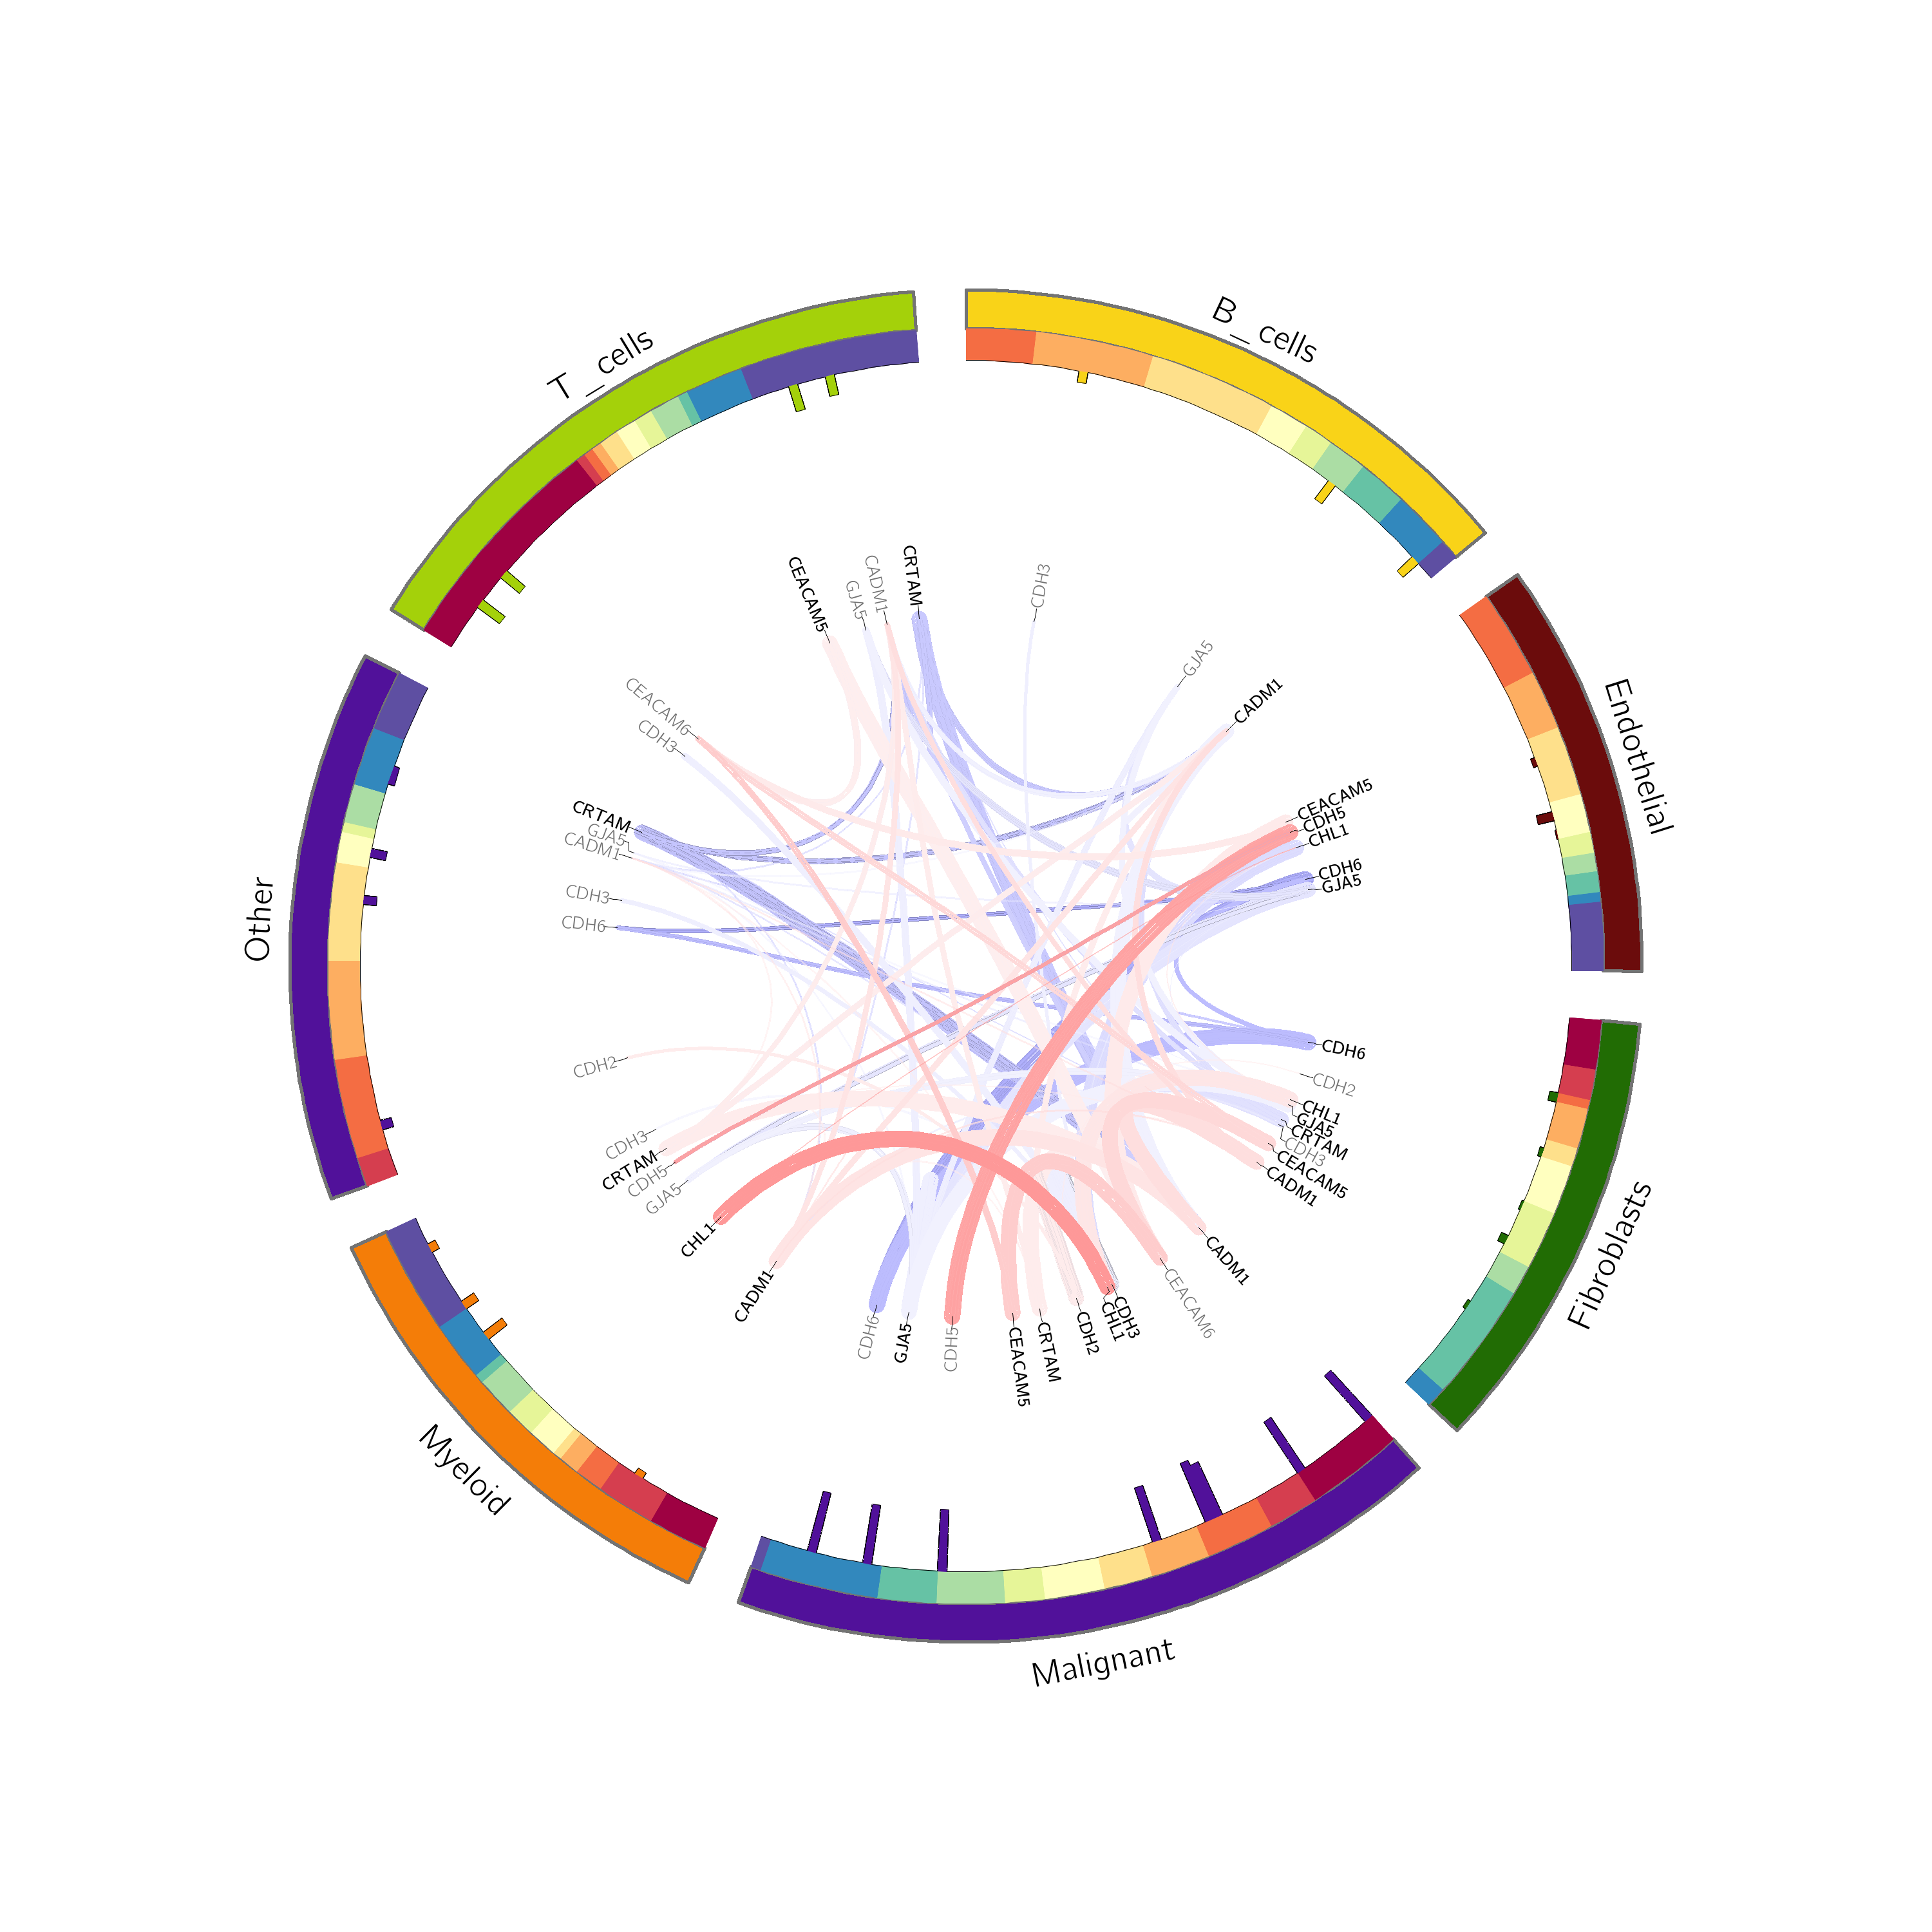

In [267]:
Image(f'circos/circos.png')

In [117]:
df.to_csv("target_strats_cart_1.csv", index=False)

In [120]:
target_stats_1 = pd.read_csv("target_strats_cart_1.csv")


In [121]:
target_stats_1

,ligand,receptor,ligand_t,receptor_t,log2Fc,fdr,ligand de,receptor de,ligand numSig,receptor numSig,dc1,dc2
0,CDH2,CDH2,Myeloid,Myeloid,-0.048711,0.000367,0.396732,0.396732,0.0,0.0,-0.941715,0.048452
1,CDH2,CDH2,Myeloid,Neuronal,-0.048711,0.000367,0.396732,0.418928,0.0,2.0,-0.941715,0.116979
2,CDH2,CDH2,Neuronal,Myeloid,-0.071462,0.018051,0.418928,0.396732,2.0,0.0,0.847194,0.048452
3,CDH2,CDH2,Neuronal,Neuronal,-0.071462,0.018051,0.418928,0.418928,2.0,2.0,0.847194,0.116979
4,CDH5,CDH5,Endothelial,Endothelial,-0.236060,0.000095,0.144355,0.144355,7.0,7.0,-1.113148,-0.156001
5,CADM1,CADM1,Myeloid,Myeloid,-0.109834,0.000172,0.506797,0.506797,0.0,0.0,-0.997385,0.061973
6,CADM1,CADM1,Myeloid,Neuronal,-0.109834,0.000172,0.506797,0.463963,0.0,0.0,-0.997385,0.154453
7,CADM1,CADM1,Neuronal,Myeloid,-0.187773,0.000060,0.463963,0.506797,0.0,0.0,0.891085,0.061973
8,CADM1,CADM1,Neuronal,Neuronal,-0.187773,0.000060,0.463963,0.463963,0.0,0.0,0.891085,0.154453
9,CADM1,NECTIN3,Myeloid,Myeloid,-0.109834,0.000172,0.506797,0.176469,0.0,0.0,-0.997385,-0.018736


In [182]:
outdir=f'{output_dir}/circos'
tmp = ct.make_circos_plot(interactions, target_stats,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=12,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.15,
                          order_col='cell_type_dc1_norm',
                          outdir=outdir, colorMap=cellType_colormap,
                          cellType_labels=True), #cellType_filter_receptor=['Tumor_cells', 'Macrophages_mMDSC'],
                          #cellType_filter_ligand='PMN_gMDSC')

Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 366
 num_receptor = 34
Removing 7 cell Types that have no labels: Myeloid,Other,T_cells,Fibroblasts,B_cells,Malignant,Endothelial
target_stats.shape = (0, 15)


/home/ubuntu/cart.contact.tracing/contactTracing_library.py:945: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_stats['type'] = pd.Categorical(target_stats['type'], categories=['receptor', 'ligand', 'both'])


In [184]:
tmp

(None,)

In [183]:
Image(f'{outdir}/circos.png')

FileNotFoundError: No such file or directory: '/home/ubuntu/durva/circos/circos.png'

FileNotFoundError: No such file or directory: '/home/ubuntu/durva/circos/circos.png'

<IPython.core.display.Image object>

__This example shows all interactions (with at least numSigI1_fdr05 >= 12 in receptor, ligand abs(logFC) > 0.15 and ligand(fdr) < 0.05)__

In [115]:
outdir=f'{output_dir}/circos_all'
tmp = ct.make_circos_plot(interactions, target_stats,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=12,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.15,
                          order_col='cell_type_dc1_norm',
                          outdir=outdir, colorMap=cellType_colormap)

Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 432
 num_receptor = 400
Removing 3 cell Types that have no labels: pDC,cDC,NK_cells
target_stats.shape = (758, 15)
Macrophages_mMDSC 281
Tumor_cells 259
PMN_gMDSC 92
T_cells 91
B_cells 30
Fibroblast_cells 5
Wrote karyotype file with 6 chromosomes and 758 genes
Number of links: : 182
Wrote /data/tutorial_output/circos_all/circos.conf
Done making circos plot /data/tutorial_output/circos_all/circos.png
Placed 119 labels


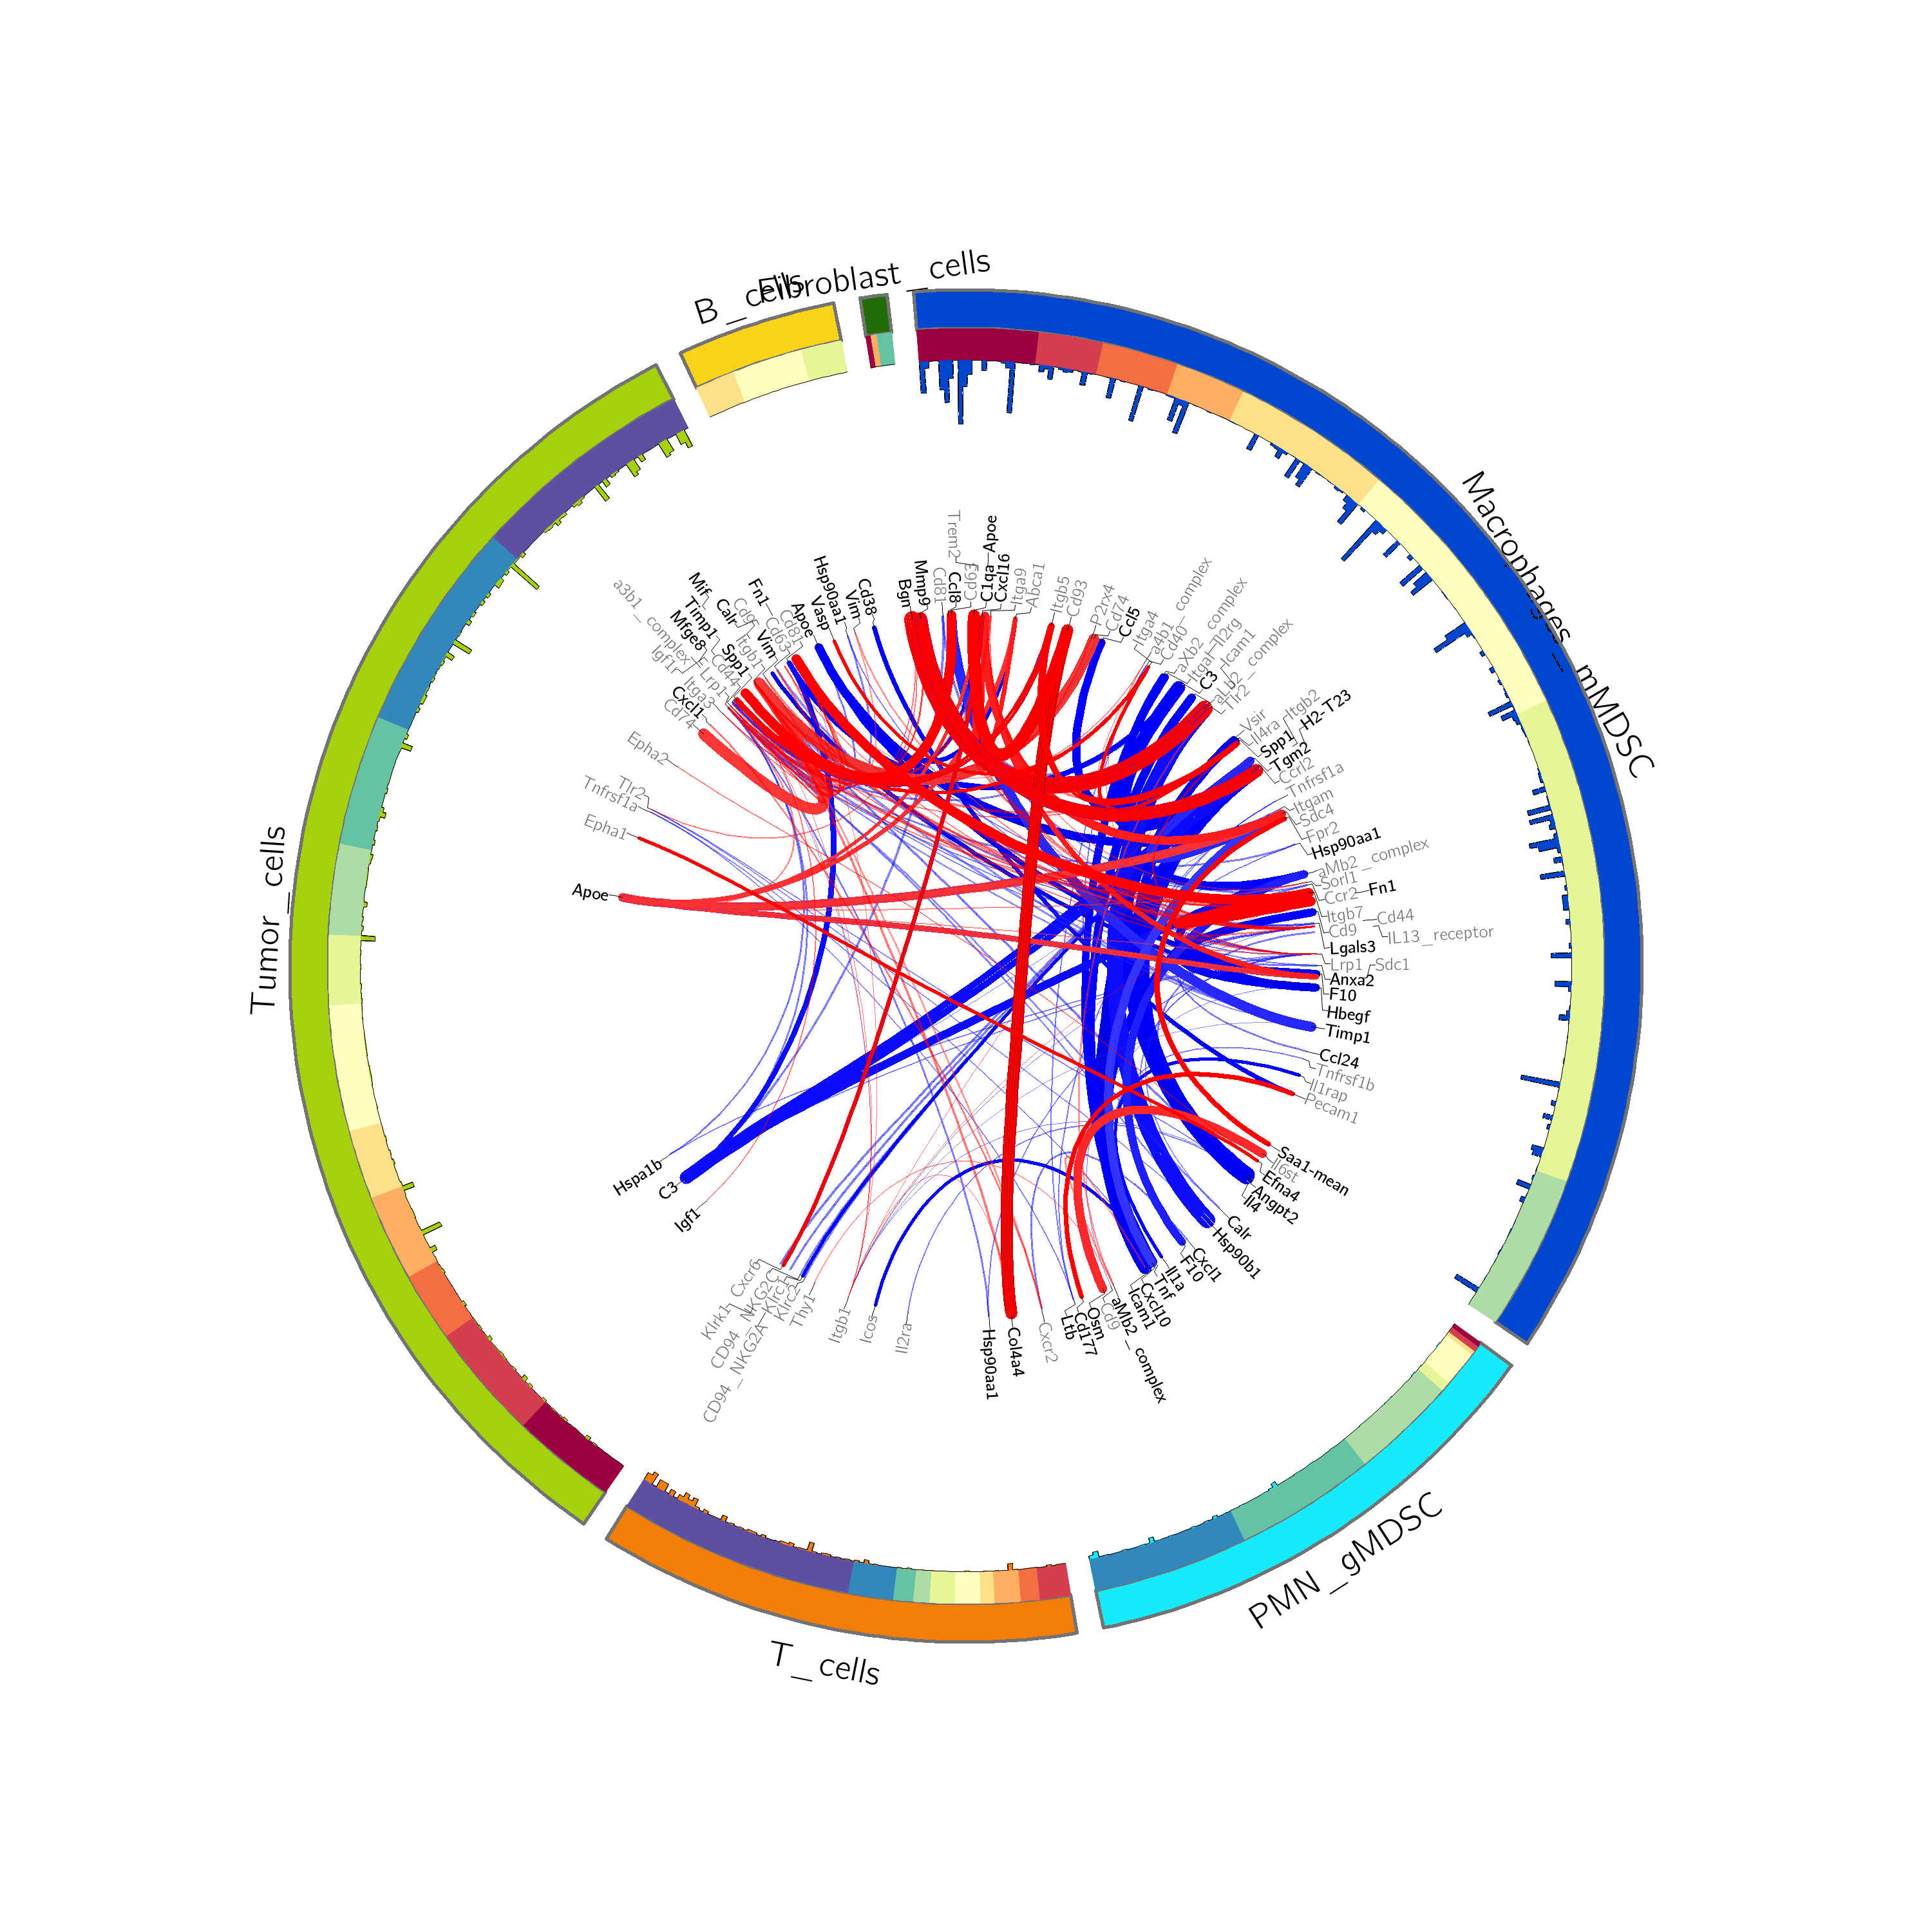

In [116]:
Image(f'{outdir}/circos.png')

# Further interactive visualization of ContactTracing results

For more options on visualizing the results, see the notebook here: https://github.com/LaughneyLab/ContactTracing-Viz/blob/master/interactive_notebook.ipynb